### what do we want from measurement.
- measurement of small functions
- measurement of big functions
- clock cycle matches real execution time

### how do we collect the data?
- unit functions
    - when function size (number of sample passed to the function) is small, the measurement is stable due to no resource stall.
    - when function size is large, the measurement varies very much due to non-predictable resource stall.
- filter function
    - resource stall can be dramatically increasing as more data are passed (stall in softward pipeline).
- Solution
    - run 10000 measurements and each measurement runs 100 repetitions
        - note: in agner's PMCTest, each measurement is relatively stable (in 100 repetitions) but not stable between different measurements
    - avoid strange point by limiting into 2 standard deviation.
        - avoid strange point in data collection and data analysis
        - two-tier filter both apply based on clock cycle
            - clock cycle is closely relavant to resource stall.
            - first tier select the data line whose clock cycle really lies in the middle.
            - second tier data analysis based on (10000-n) filtered data
- Goal
    - the time measurement for filter function when passing a large number of data (e.g.,2**19) should have a close relationship between measured clock cycle in terms of mean and standard deviation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Table read helper function

In [2]:
from pyexcel_ods3 import get_data
import json

def read_ods_as_nested_dict(filename):
    """
    Nested dictionary grouped by operation -> vector_length -> block_size
    Great for hierarchical access
    FIXED: Strips trailing spaces from headers
    """
    data = get_data(filename)
    sheet_data = data['Sheet1']
    
    # FIXED: Strip spaces from headers
    headers = [header.strip() if isinstance(header, str) else header 
               for header in sheet_data[0][1:]]  # Skip first empty header
    
    result = {}
    current_operation = None
    
    for row in sheet_data[1:]:
        if not row or all(x is None or x == '' for x in row):
            continue
            
        if row[0] is not None and row[0] != '':
            current_operation = row[0]
        
        if current_operation not in result:
            result[current_operation] = {}
        
        # Get vector length and block size
        vector_length = row[1] if len(row) > 1 else None
        block_size = row[2] if len(row) > 2 else None
        
        if vector_length not in result[current_operation]:
            result[current_operation][vector_length] = {}
        
        # Store all metrics for this combination
        metrics = {}
        for i, header in enumerate(headers[2:], 3):  # Skip vector_length and block_size
            if i < len(row):
                # FIXED: Use stripped header as key
                metrics[header] = row[i]
        
        result[current_operation][vector_length][block_size] = metrics
    
    return result

agner_pmc = read_ods_as_nested_dict('agner_measurement_table.ods')

agner_pmc.keys()

dict_keys(['permute', 'depermute', 'fir cores', 'part sol', 'homo sol', 'cr forward', 'cr backward', 'iir ph', 'iir cr', 'block filtering', 'scalar', 'filter scalar 2', 'filter scalar 4', 'filter scalar 8', 'filter scalar 16', 'filter bf 2', 'filter bf 4', 'filter bf 8', 'filter bf 16', 'filter ph 2', 'filter cr 2', 'filter ph 4', 'filter cr 4', 'filter ph 8', 'filter cr 8', 'filter ph 16', 'filter cr 16', 'filter ph 2 real', 'filter cr 2 real', 'filter ph 4 real', 'filter cr 4 real', 'filter ph 8 real', 'filter cr 8 real', 'filter ph 16 real', 'filter cr 16 real', 'filter bf 2 real', 'filter bf 4 real', 'filter bf 8 real', 'filter bf 16 real', 'filter scalar 2 real', 'filter scalar 4 real', 'filter scalar 8 real', 'filter scalar 16 real'])

In [3]:
def remove_large_sample_key(data):
    """Remove 512 from all [function][8] and 1024 from all [function][4]"""
    for function_name in data:
        # Remove 512 from [function][8] if it exists
        if 8 in data[function_name] and 512 in data[function_name][8]:
            del data[function_name][8][512]
        
        # Remove 1024 from [function][4] if it exists  
        if 4 in data[function_name] and 1024 in data[function_name][4]:
            del data[function_name][4][1024]

remove_large_sample_key(agner_pmc)  # or remove_keys_method2(your_data)

agner_pmc['permute'][8].keys()

dict_keys([8, 16, 32, 64, 128, 256])

### Measurement analysis start

1. small functions
- performance in terms of N
- performance in terms of L

Permute
- number of operation: Nlog2(L)
    - ops: log2(L)/L
        - L=4, 1/2; L=8, 3/8; L=16, 1/4
    - big L takes benefits from
        - less ops
        - more importantly, half L takes double N, perhaps more than double resource stall.

In [4]:
pm_pmc8 = agner_pmc['permute'][8]
pm_pmc4 = dict(list(agner_pmc['permute'][4].items())[2:])

pm_cps8 = np.array([metrics['cps'] for metrics in pm_pmc8.values()])
pm_cps4 = np.array([metrics['cps'] for metrics in pm_pmc4.values()])

pm_ips8 = np.array([metrics['ips'] for metrics in pm_pmc8.values()])
pm_ips4 = np.array([metrics['ips'] for metrics in pm_pmc4.values()])

pm_ipc8 = np.array([metrics['ipc'] for metrics in pm_pmc8.values()])
pm_ipc4 = np.array([metrics['ipc'] for metrics in pm_pmc4.values()])

pm_rsr8 = np.array([metrics['rsr'] for metrics in pm_pmc8.values()])
pm_rsr4 = np.array([metrics['rsr'] for metrics in pm_pmc4.values()])

pm_rss8 = np.array([metrics['rss'] for metrics in pm_pmc8.values()])
pm_rss4 = np.array([metrics['rss'] for metrics in pm_pmc4.values()])

pm_rs8 = np.array([metrics['resource stall'] for metrics in pm_pmc8.values()])
pm_rs4 = np.array([metrics['resource stall'] for metrics in pm_pmc4.values()])

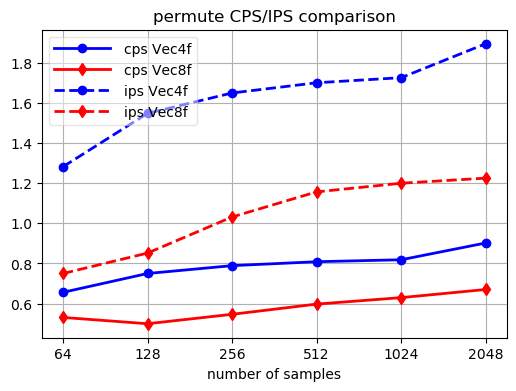

In [5]:
sample_len = np.array(list(pm_pmc8))*8
x = np.arange(len(sample_len))

plt.figure(figsize=(6, 4))  

plt.plot(x, pm_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, pm_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, pm_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, pm_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

performance for permute: Vec4f < Vec8f for all sample length if there is no extra resource stall.

Vec4f has larger ips for all cases due to larger N (less vector size for SIMD).

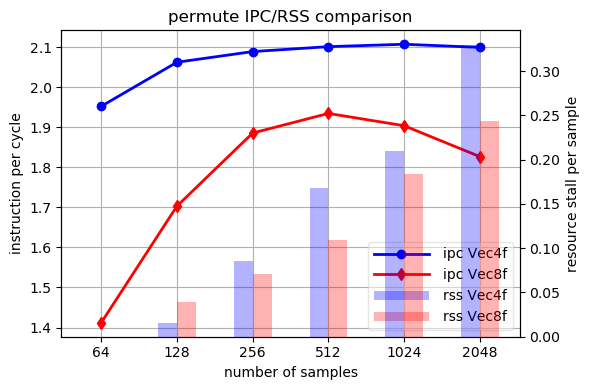

In [6]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, pm_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, pm_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, pm_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, pm_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('permute IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Depermute
- number of operation: Nlog2(L)
    - ops: log2(L)/L
        - L=4, 1/2; L=8, 3/8; L=16, 1/4
    - big L takes benefits from
        - less ops
        - more importantly, half L takes double N, perhaps more than double resource stall.

In [7]:
depm_pmc8 = agner_pmc['depermute'][8]
depm_pmc4 = dict(list(agner_pmc['depermute'][4].items())[2:])

depm_cps8 = np.array([metrics['cps'] for metrics in depm_pmc8.values()])
depm_cps4 = np.array([metrics['cps'] for metrics in depm_pmc4.values()])

depm_ips8 = np.array([metrics['ips'] for metrics in depm_pmc8.values()])
depm_ips4 = np.array([metrics['ips'] for metrics in depm_pmc4.values()])

depm_ipc8 = np.array([metrics['ipc'] for metrics in depm_pmc8.values()])
depm_ipc4 = np.array([metrics['ipc'] for metrics in depm_pmc4.values()])

depm_rsr8 = np.array([metrics['rsr'] for metrics in depm_pmc8.values()])
depm_rsr4 = np.array([metrics['rsr'] for metrics in depm_pmc4.values()])

depm_rss8 = np.array([metrics['rss'] for metrics in depm_pmc8.values()])
depm_rss4 = np.array([metrics['rss'] for metrics in depm_pmc4.values()])

depm_rs8 = np.array([metrics['resource stall'] for metrics in depm_pmc8.values()])
depm_rs4 = np.array([metrics['resource stall'] for metrics in depm_pmc4.values()])

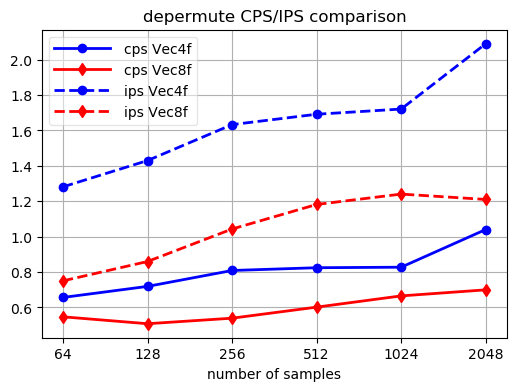

In [8]:
plt.figure(figsize=(6, 4))  

plt.plot(x, depm_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, depm_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, depm_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, depm_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('depermute CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

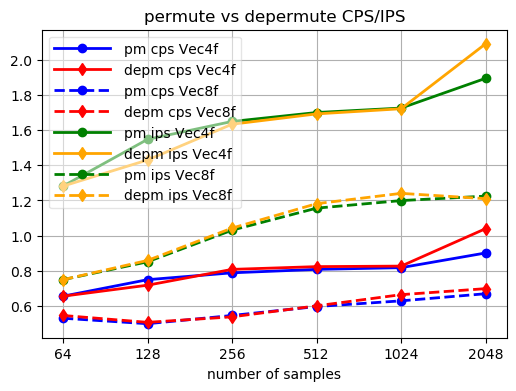

In [9]:
plt.figure(figsize=(6, 4))  

plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='blue', linewidth=2)
plt.plot(x, depm_cps4, '-d', label='depm cps Vec4f', color='red', linewidth=2)

plt.plot(x, pm_cps8, '--o', label='pm cps Vec8f', color='blue', linewidth=2)
plt.plot(x, depm_cps8, '--d', label='depm cps Vec8f', color='red', linewidth=2)

plt.plot(x, pm_ips4, '-o', label='pm ips Vec4f', color='green', linewidth=2)
plt.plot(x, depm_ips4, '-d', label='depm ips Vec4f', color='orange', linewidth=2)

plt.plot(x, pm_ips8, '--o', label='pm ips Vec8f', color='green', linewidth=2)
plt.plot(x, depm_ips8, '--d', label='depm ips Vec8f', color='orange', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute vs depermute CPS/IPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

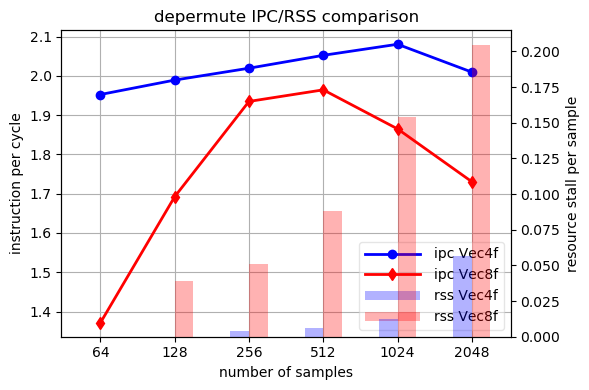

In [10]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, depm_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, depm_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, depm_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, depm_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('depermute IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Fir cores
- number of operation: 2N
    - ops: 2/L
        - L=4, 1/2; L=8, 1/4; L=16, 1/8
        - close ops as (de)permute
    - big L takes benefits from
        - less ops
        - more importantly, half L takes double N, perhaps more than double resource stall.

In [11]:
fir_pmc8 = agner_pmc['fir cores'][8]
fir_pmc4 = dict(list(agner_pmc['fir cores'][4].items())[2:])

fir_cps8 = np.array([metrics['cps'] for metrics in fir_pmc8.values()])
fir_cps4 = np.array([metrics['cps'] for metrics in fir_pmc4.values()])

fir_ips8 = np.array([metrics['ips'] for metrics in fir_pmc8.values()])
fir_ips4 = np.array([metrics['ips'] for metrics in fir_pmc4.values()])

fir_ipc8 = np.array([metrics['ipc'] for metrics in fir_pmc8.values()])
fir_ipc4 = np.array([metrics['ipc'] for metrics in fir_pmc4.values()])

fir_rsr8 = np.array([metrics['rsr'] for metrics in fir_pmc8.values()])
fir_rsr4 = np.array([metrics['rsr'] for metrics in fir_pmc4.values()])

fir_rss8 = np.array([metrics['rss'] for metrics in fir_pmc8.values()])
fir_rss4 = np.array([metrics['rss'] for metrics in fir_pmc4.values()])

fir_rs8 = np.array([metrics['resource stall'] for metrics in fir_pmc8.values()])
fir_rs4 = np.array([metrics['resource stall'] for metrics in fir_pmc4.values()])

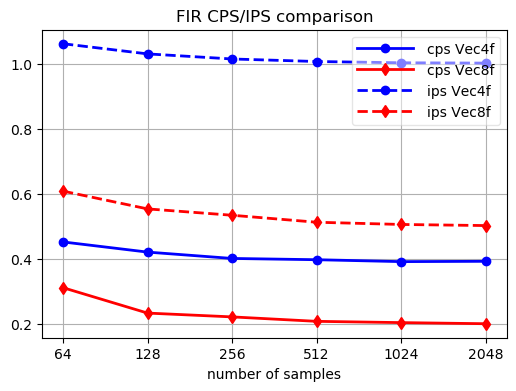

In [12]:
plt.figure(figsize=(6, 4))  

plt.plot(x, fir_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, fir_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, fir_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, fir_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('FIR CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

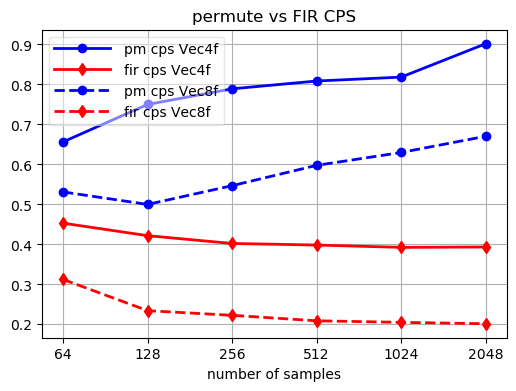

In [13]:
plt.figure(figsize=(6, 4))  

plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='blue', linewidth=2)
plt.plot(x, fir_cps4, '-d', label='fir cps Vec4f', color='red', linewidth=2)

plt.plot(x, pm_cps8, '--o', label='pm cps Vec8f', color='blue', linewidth=2)
plt.plot(x, fir_cps8, '--d', label='fir cps Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute vs FIR CPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

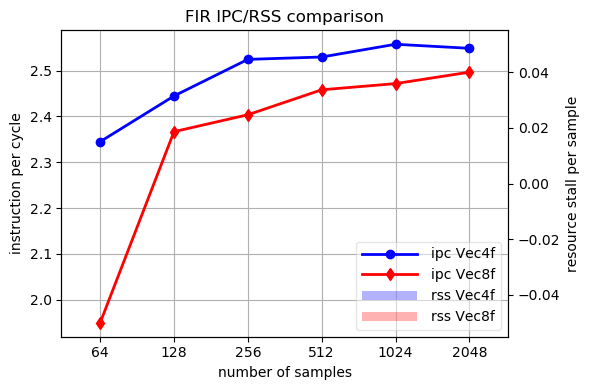

In [14]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, fir_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, fir_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, fir_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, fir_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('FIR IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

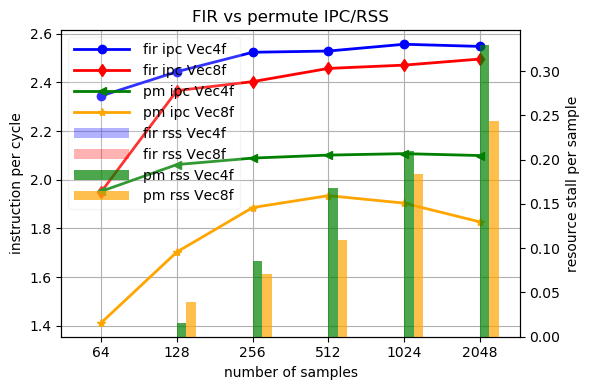

In [15]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                  

ax2.bar(x1, fir_rss4, width=bar_width, color='blue', alpha=0.3,label='fir rss Vec4f')
ax2.bar(x2, fir_rss8, width=bar_width, color='red', alpha=0.3, label='fir rss Vec8f')
ax2.bar(x3, pm_rss4, width=bar_width, color='green', alpha=0.7,label='pm rss Vec4f')
ax2.bar(x4, pm_rss8, width=bar_width, color='orange', alpha=0.7, label='pm rss Vec8f')
ax1.plot(x, fir_ipc4, color='blue', marker='o', linewidth=2, label='fir ipc Vec4f')
ax1.plot(x, fir_ipc8, color='red', marker='d', linewidth=2, label='fir ipc Vec8f')
ax1.plot(x, pm_ipc4, color='green', marker='<', linewidth=2, label='pm ipc Vec4f')
ax1.plot(x, pm_ipc8, color='orange', marker='*', linewidth=2, label='pm ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('FIR vs permute IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

close ops, permute has more resource stall (data dependency) thus less ipc and cps.

Particular solution
- number of operation: 2N-3
    - ops: 2/L-3/(NL)
        - approximately: L=4, 1/2; L=8, 1/4; L=16, 1/8
        - close ops as (de)permute
    - big L takes benefits from
        - less ops
        - more importantly, half L takes double N, perhaps more than double resource stall.

In [16]:
ps_pmc8 = agner_pmc['part sol'][8]
ps_pmc4 = dict(list(agner_pmc['part sol'][4].items())[2:])

ps_cps8 = np.array([metrics['cps'] for metrics in ps_pmc8.values()])
ps_cps4 = np.array([metrics['cps'] for metrics in ps_pmc4.values()])

ps_ips8 = np.array([metrics['ips'] for metrics in ps_pmc8.values()])
ps_ips4 = np.array([metrics['ips'] for metrics in ps_pmc4.values()])

ps_ipc8 = np.array([metrics['ipc'] for metrics in ps_pmc8.values()])
ps_ipc4 = np.array([metrics['ipc'] for metrics in ps_pmc4.values()])

ps_rsr8 = np.array([metrics['rsr'] for metrics in ps_pmc8.values()])
ps_rsr4 = np.array([metrics['rsr'] for metrics in ps_pmc4.values()])

ps_rss8 = np.array([metrics['rss'] for metrics in ps_pmc8.values()])
ps_rss4 = np.array([metrics['rss'] for metrics in ps_pmc4.values()])

ps_rs8 = np.array([metrics['resource stall'] for metrics in ps_pmc8.values()])
ps_rs4 = np.array([metrics['resource stall'] for metrics in ps_pmc4.values()])

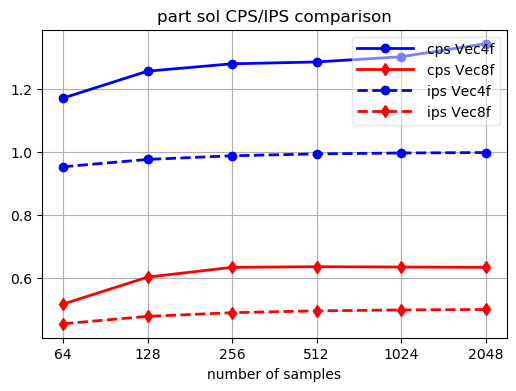

In [17]:
plt.figure(figsize=(6, 4))  

plt.plot(x, ps_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, ps_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, ps_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, ps_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('part sol CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

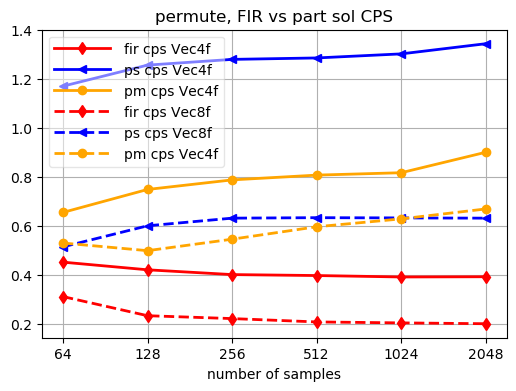

In [18]:
plt.figure(figsize=(6, 4))  

plt.plot(x, fir_cps4, '-d', label='fir cps Vec4f', color='red', linewidth=2)
plt.plot(x, ps_cps4, '-<', label='ps cps Vec4f', color='blue', linewidth=2)
plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='orange', linewidth=2)

plt.plot(x, fir_cps8, '--d', label='fir cps Vec8f', color='red', linewidth=2)
plt.plot(x, ps_cps8, '--<', label='ps cps Vec8f', color='blue', linewidth=2)
plt.plot(x, pm_cps8, '--o', label='pm cps Vec4f', color='orange', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute, FIR vs part sol CPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

permute is more expensive at large data size.

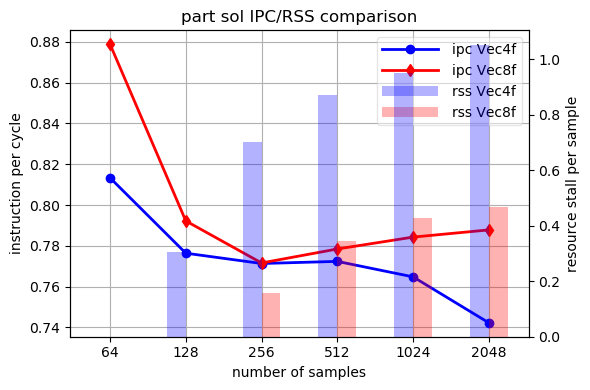

In [19]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, ps_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, ps_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, ps_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, ps_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('part sol IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

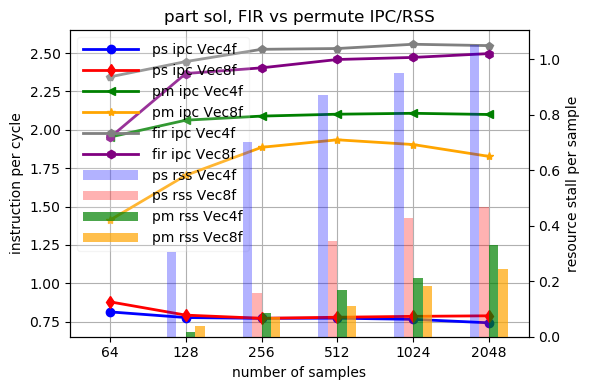

In [20]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                  

ax2.bar(x1, ps_rss4, width=bar_width, color='blue', alpha=0.3,label='ps rss Vec4f')
ax2.bar(x2, ps_rss8, width=bar_width, color='red', alpha=0.3, label='ps rss Vec8f')
ax2.bar(x3, pm_rss4, width=bar_width, color='green', alpha=0.7,label='pm rss Vec4f')
ax2.bar(x4, pm_rss8, width=bar_width, color='orange', alpha=0.7, label='pm rss Vec8f')
ax1.plot(x, ps_ipc4, color='blue', marker='o', linewidth=2, label='ps ipc Vec4f')
ax1.plot(x, ps_ipc8, color='red', marker='d', linewidth=2, label='ps ipc Vec8f')
ax1.plot(x, pm_ipc4, color='green', marker='<', linewidth=2, label='pm ipc Vec4f')
ax1.plot(x, pm_ipc8, color='orange', marker='*', linewidth=2, label='pm ipc Vec8f')
ax1.plot(x, fir_ipc4, color='gray', marker='p', linewidth=2, label='fir ipc Vec4f')
ax1.plot(x, fir_ipc8, color='purple', marker='h', linewidth=2, label='fir ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('part sol, FIR vs permute IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

we can clearly see the ranking of data dependency (resource stall), which also stands for the ranking of performance (CPS)

Homogeneous solution
- number of operation: 6log2(L)+2N+4
    - ops: $2/L+\frac{6\log_2(L)+4}{NL}$
- first large then small data dependency
    - small N: recursive doubling dominates, high data dependecy
    - large N: forward dominates, small data dependency

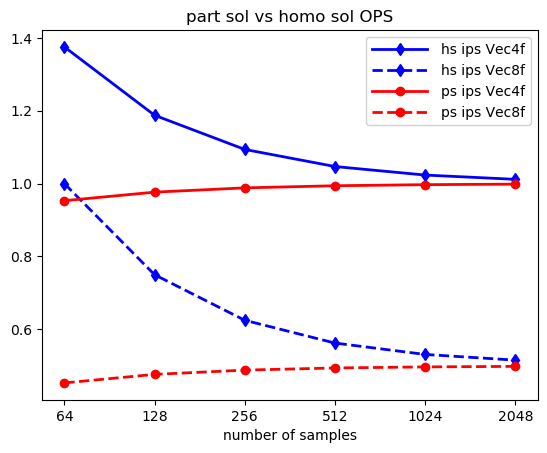

In [21]:
ps_ops = np.zeros((2,len(sample_len)),dtype=float)
hs_ops = np.zeros((2,len(sample_len)),dtype=float)

for n in range(1,3):
    L = 4*n
    N = sample_len/L
    hs_fma = 4*np.log2(L) + 2*N
    hs_shuf = 2*np.log2(L) + 4
    hs_ops[n-1] = (hs_fma + 2*hs_shuf + 2*N)/sample_len 
    ps_fma = 2*N-3
    ps_shuf = 0
    ps_ops[n-1] = (ps_fma + 2*ps_shuf + 2*N)/sample_len

plt.plot(x, hs_ops[0], '-d', label='hs ips Vec4f', color='blue', linewidth=2)
plt.plot(x, hs_ops[1], '--d', label='hs ips Vec8f', color='blue', linewidth=2)
plt.plot(x, ps_ops[0], '-o', label='ps ips Vec4f', color='red', linewidth=2)
plt.plot(x, ps_ops[1], '--o', label='ps ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('part sol vs homo sol OPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.show()

In [22]:
hs_pmc8 = agner_pmc['homo sol'][8]
hs_pmc4 = dict(list(agner_pmc['homo sol'][4].items())[2:])

hs_cps8 = np.array([metrics['cps'] for metrics in hs_pmc8.values()])
hs_cps4 = np.array([metrics['cps'] for metrics in hs_pmc4.values()])

hs_ips8 = np.array([metrics['ips'] for metrics in hs_pmc8.values()])
hs_ips4 = np.array([metrics['ips'] for metrics in hs_pmc4.values()])

hs_ipc8 = np.array([metrics['ipc'] for metrics in hs_pmc8.values()])
hs_ipc4 = np.array([metrics['ipc'] for metrics in hs_pmc4.values()])

hs_rsr8 = np.array([metrics['rsr'] for metrics in hs_pmc8.values()])
hs_rsr4 = np.array([metrics['rsr'] for metrics in hs_pmc4.values()])

hs_rss8 = np.array([metrics['rss'] for metrics in hs_pmc8.values()])
hs_rss4 = np.array([metrics['rss'] for metrics in hs_pmc4.values()])

hs_rs8 = np.array([metrics['resource stall'] for metrics in hs_pmc8.values()])
hs_rs4 = np.array([metrics['resource stall'] for metrics in hs_pmc4.values()])

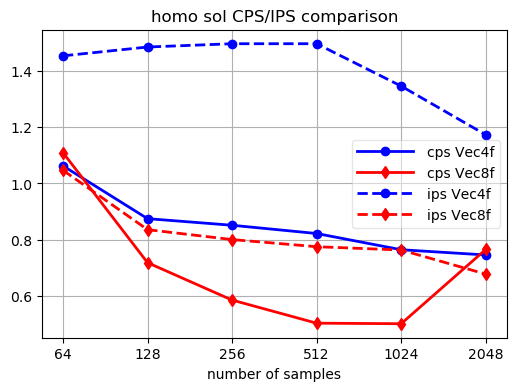

In [23]:
plt.figure(figsize=(6, 4))  

plt.plot(x, hs_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, hs_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, hs_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, hs_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('homo sol CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

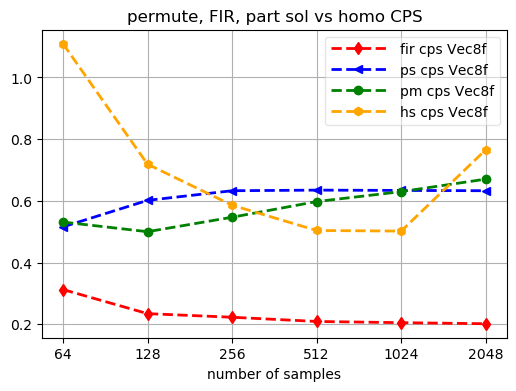

In [24]:
plt.figure(figsize=(6, 4))  

# plt.plot(x, fir_cps4, '-d', label='fir cps Vec4f', color='red', linewidth=2)
# plt.plot(x, ps_cps4, '-<', label='ps cps Vec4f', color='blue', linewidth=2)
# plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='green', linewidth=2)
# plt.plot(x, hs_cps4, '-h', label='hs cps Vec4f', color='orange', linewidth=2)

plt.plot(x, fir_cps8, '--d', label='fir cps Vec8f', color='red', linewidth=2)
plt.plot(x, ps_cps8, '--<', label='ps cps Vec8f', color='blue', linewidth=2)
plt.plot(x, pm_cps8, '--o', label='pm cps Vec8f', color='green', linewidth=2)
plt.plot(x, hs_cps8, '--h', label='hs cps Vec8f', color='orange', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute, FIR, part sol vs homo CPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

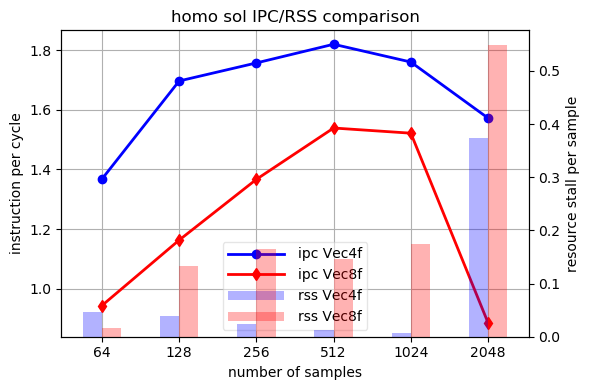

In [25]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, hs_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, hs_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, hs_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, hs_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('homo sol IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Cyclic reduction forward
- number of operation: log2(N)+2N-2
    - ops: $2/L+\frac{\log_2(N)-2}{NL}$
- first medium then small data dependency
    - large N: in loop parallelism

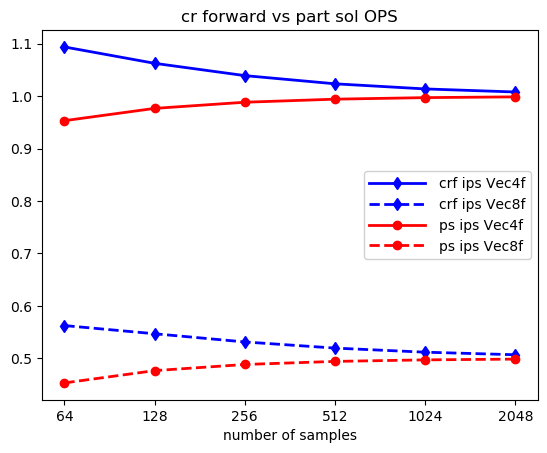

In [26]:
crf_ops = np.zeros((2,len(sample_len)),dtype=float)

for n in range(1,3):
    L = 4*n
    N = sample_len/L
    crf_fma = 2*N-2
    crf_shuf = np.log2(N)
    crf_ops[n-1] = (crf_fma + 2*crf_shuf + 2*N)/sample_len 


plt.plot(x, crf_ops[0], '-d', label='crf ips Vec4f', color='blue', linewidth=2)
plt.plot(x, crf_ops[1], '--d', label='crf ips Vec8f', color='blue', linewidth=2)
plt.plot(x, ps_ops[0], '-o', label='ps ips Vec4f', color='red', linewidth=2)
plt.plot(x, ps_ops[1], '--o', label='ps ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('cr forward vs part sol OPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.show()

In [27]:
crf_pmc8 = agner_pmc['cr forward'][8]
crf_pmc4 = dict(list(agner_pmc['cr forward'][4].items())[2:])

crf_cps8 = np.array([metrics['cps'] for metrics in crf_pmc8.values()])
crf_cps4 = np.array([metrics['cps'] for metrics in crf_pmc4.values()])

crf_ips8 = np.array([metrics['ips'] for metrics in crf_pmc8.values()])
crf_ips4 = np.array([metrics['ips'] for metrics in crf_pmc4.values()])

crf_ipc8 = np.array([metrics['ipc'] for metrics in crf_pmc8.values()])
crf_ipc4 = np.array([metrics['ipc'] for metrics in crf_pmc4.values()])

crf_rsr8 = np.array([metrics['rsr'] for metrics in crf_pmc8.values()])
crf_rsr4 = np.array([metrics['rsr'] for metrics in crf_pmc4.values()])

crf_rss8 = np.array([metrics['rss'] for metrics in crf_pmc8.values()])
crf_rss4 = np.array([metrics['rss'] for metrics in crf_pmc4.values()])

crf_rs8 = np.array([metrics['resource stall'] for metrics in crf_pmc8.values()])
crf_rs4 = np.array([metrics['resource stall'] for metrics in crf_pmc4.values()])

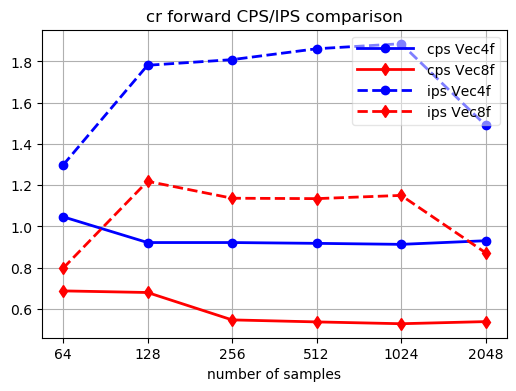

In [28]:
plt.figure(figsize=(6, 4))  

plt.plot(x, crf_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, crf_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, crf_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, crf_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('cr forward CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

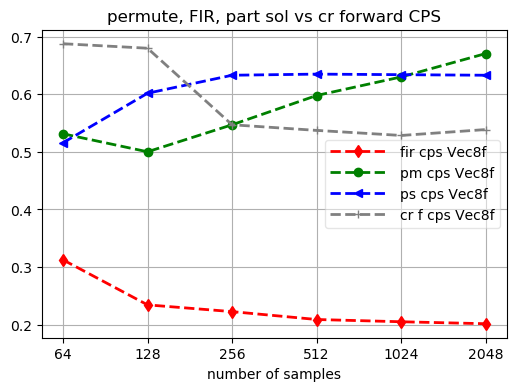

In [29]:
plt.figure(figsize=(6, 4))  

# plt.plot(x, fir_cps4, '-d', label='fir cps Vec4f', color='red', linewidth=2)
# plt.plot(x, ps_cps4, '-<', label='ps cps Vec4f', color='blue', linewidth=2)
# plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='green', linewidth=2)
# plt.plot(x, hs_cps4, '-h', label='hs cps Vec4f', color='orange', linewidth=2)
# plt.plot(x, crf_cps4, '-+', label='crf cps Vec4f', color='gray', linewidth=2)

plt.plot(x, fir_cps8, '--d', label='fir cps Vec8f', color='red', linewidth=2)
plt.plot(x, pm_cps8, '--o', label='pm cps Vec8f', color='green', linewidth=2)
plt.plot(x, ps_cps8, '--<', label='ps cps Vec8f', color='blue', linewidth=2)
# plt.plot(x, hs_cps8, '--h', label='hs cps Vec8f', color='orange', linewidth=2)
plt.plot(x, crf_cps8, '--+', label='cr f cps Vec8f', color='gray', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute, FIR, part sol vs cr forward CPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

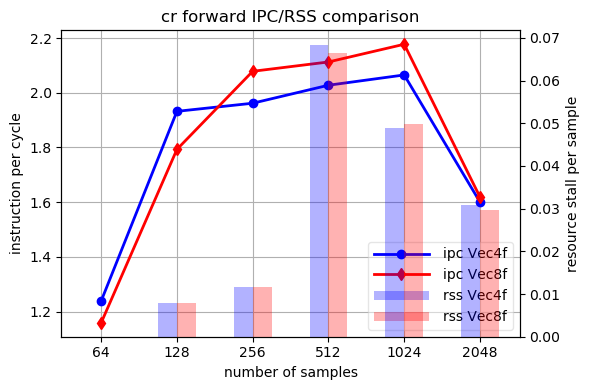

In [30]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, crf_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, crf_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, crf_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, crf_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('cr forward IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

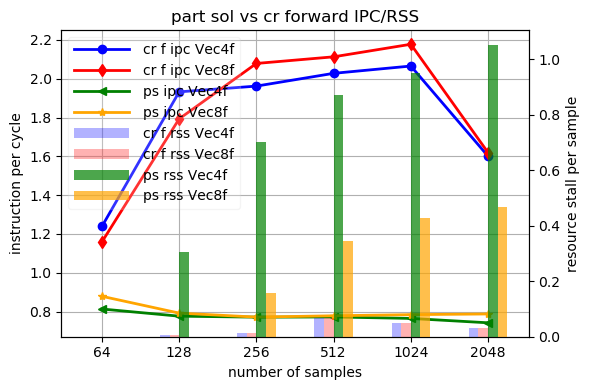

In [31]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                  

ax2.bar(x1, crf_rss4, width=bar_width, color='blue', alpha=0.3,label='cr f rss Vec4f')
ax2.bar(x2, crf_rss8, width=bar_width, color='red', alpha=0.3, label='cr f rss Vec8f')
ax2.bar(x3, ps_rss4, width=bar_width, color='green', alpha=0.7,label='ps rss Vec4f')
ax2.bar(x4, ps_rss8, width=bar_width, color='orange', alpha=0.7, label='ps rss Vec8f')
ax1.plot(x, crf_ipc4, color='blue', marker='o', linewidth=2, label='cr f ipc Vec4f')
ax1.plot(x, crf_ipc8, color='red', marker='d', linewidth=2, label='cr f ipc Vec8f')
ax1.plot(x, ps_ipc4, color='green', marker='<', linewidth=2, label='ps ipc Vec4f')
ax1.plot(x, ps_ipc8, color='orange', marker='*', linewidth=2, label='ps ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('part sol vs cr forward IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

Cyclic reduction backward
- number of operation: log2(N)+2N+L+2
    - ops: $2/L+1/N+\frac{\log_2(N)+2}{NL}$
- first medium then small data dependency
    - large N: in loop parallelism

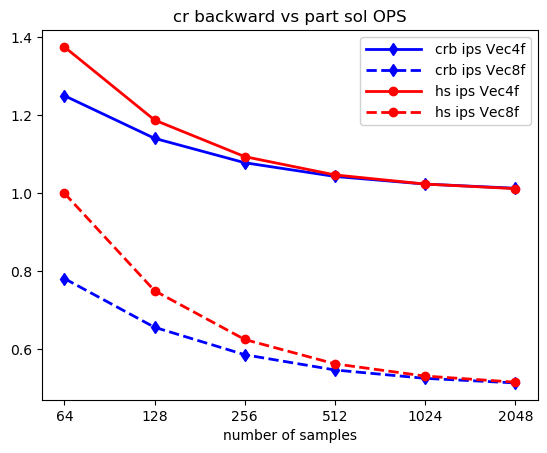

In [32]:
crb_ops = np.zeros((2,len(sample_len)),dtype=float)

for n in range(1,3):
    L = 4*n
    N = sample_len/L
    crb_fma = 2*N+L
    crb_shuf = np.log2(N)+2
    crb_ops[n-1] = (crb_fma + 2*crb_shuf + 2*N)/sample_len 


plt.plot(x, crb_ops[0], '-d', label='crb ips Vec4f', color='blue', linewidth=2)
plt.plot(x, crb_ops[1], '--d', label='crb ips Vec8f', color='blue', linewidth=2)
plt.plot(x, hs_ops[0], '-o', label='hs ips Vec4f', color='red', linewidth=2)
plt.plot(x, hs_ops[1], '--o', label='hs ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('cr backward vs part sol OPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.show()

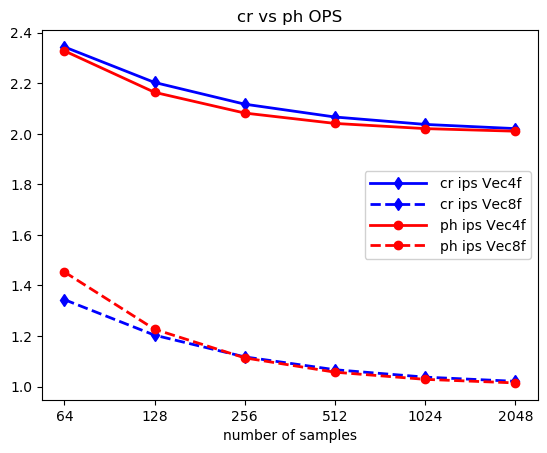

In [33]:
plt.plot(x, crb_ops[0]+crf_ops[0], '-d', label='cr ips Vec4f', color='blue', linewidth=2)
plt.plot(x, crb_ops[1]+crf_ops[1], '--d', label='cr ips Vec8f', color='blue', linewidth=2)
plt.plot(x, hs_ops[0]+ps_ops[0], '-o', label='ph ips Vec4f', color='red', linewidth=2)
plt.plot(x, hs_ops[1]+ps_ops[1], '--o', label='ph ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('cr vs ph OPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.show()

In [34]:
crb_pmc8 = agner_pmc['cr backward'][8]
crb_pmc4 = dict(list(agner_pmc['cr backward'][4].items())[2:])

crb_cps8 = np.array([metrics['cps'] for metrics in crb_pmc8.values()])
crb_cps4 = np.array([metrics['cps'] for metrics in crb_pmc4.values()])

crb_ips8 = np.array([metrics['ips'] for metrics in crb_pmc8.values()])
crb_ips4 = np.array([metrics['ips'] for metrics in crb_pmc4.values()])

crb_ipc8 = np.array([metrics['ipc'] for metrics in crb_pmc8.values()])
crb_ipc4 = np.array([metrics['ipc'] for metrics in crb_pmc4.values()])

crb_rsr8 = np.array([metrics['rsr'] for metrics in crb_pmc8.values()])
crb_rsr4 = np.array([metrics['rsr'] for metrics in crb_pmc4.values()])

crb_rss8 = np.array([metrics['rss'] for metrics in crb_pmc8.values()])
crb_rss4 = np.array([metrics['rss'] for metrics in crb_pmc4.values()])

crb_rs8 = np.array([metrics['resource stall'] for metrics in crb_pmc8.values()])
crb_rs4 = np.array([metrics['resource stall'] for metrics in crb_pmc4.values()])

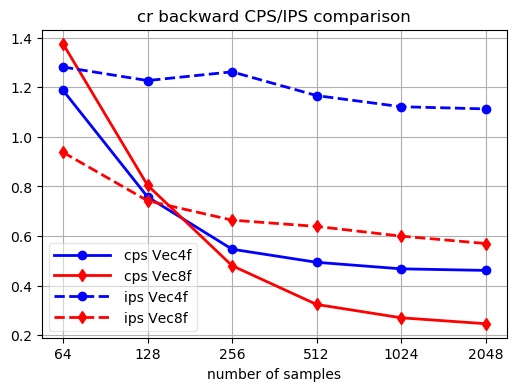

In [35]:
plt.figure(figsize=(6, 4))  

plt.plot(x, crb_cps4, '-o', label='cps Vec4f', color='blue', linewidth=2)
plt.plot(x, crb_cps8, '-d', label='cps Vec8f', color='red', linewidth=2)

plt.plot(x, crb_ips4, '--o', label='ips Vec4f', color='blue', linewidth=2)
plt.plot(x, crb_ips8, '--d', label='ips Vec8f', color='red', linewidth=2)

plt.xticks(x,sample_len)
plt.title('cr backward CPS/IPS comparison')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

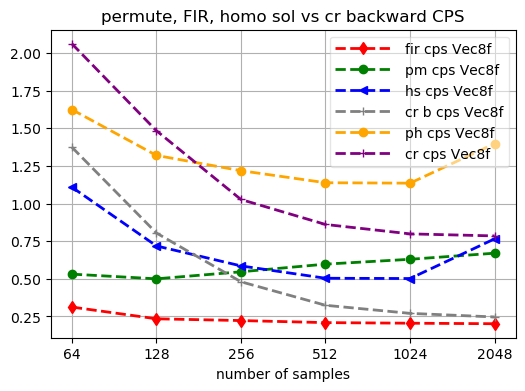

In [36]:
plt.figure(figsize=(6, 4))  

# plt.plot(x, fir_cps4, '-d', label='fir cps Vec4f', color='red', linewidth=2)
# plt.plot(x, ps_cps4, '-<', label='ps cps Vec4f', color='blue', linewidth=2)
# plt.plot(x, pm_cps4, '-o', label='pm cps Vec4f', color='green', linewidth=2)
# plt.plot(x, hs_cps4, '-h', label='hs cps Vec4f', color='orange', linewidth=2)
# plt.plot(x, crf_cps4, '-+', label='crf cps Vec4f', color='gray', linewidth=2)

plt.plot(x, fir_cps8, '--d', label='fir cps Vec8f', color='red', linewidth=2)
plt.plot(x, pm_cps8, '--o', label='pm cps Vec8f', color='green', linewidth=2)
plt.plot(x, hs_cps8, '--<', label='hs cps Vec8f', color='blue', linewidth=2)
plt.plot(x, crb_cps8, '--+', label='cr b cps Vec8f', color='gray', linewidth=2)
plt.plot(x, ps_cps8+hs_cps8, '--o', label='ph cps Vec8f', color='orange', linewidth=2)
plt.plot(x, crf_cps8+crb_cps8, '--+', label='cr cps Vec8f', color='purple', linewidth=2)

plt.xticks(x,sample_len)
plt.title('permute, FIR, homo sol vs cr backward CPS')
plt.xlabel('number of samples')
plt.ylabel('')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)
plt.grid()
plt.show()

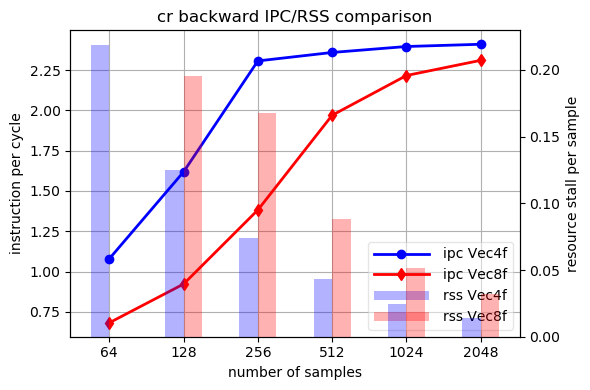

In [37]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, crb_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, crb_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, crb_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, crb_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('cr backward IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

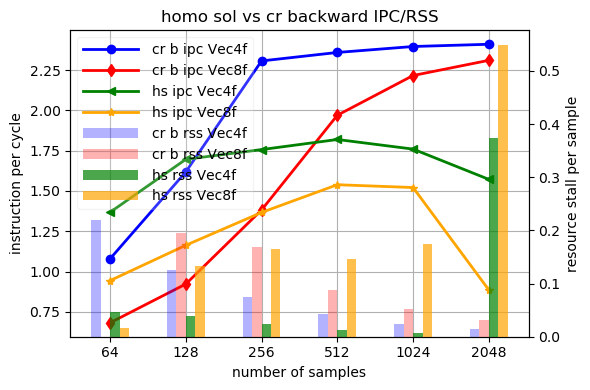

In [38]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                  

ax2.bar(x1, crb_rss4, width=bar_width, color='blue', alpha=0.3,label='cr b rss Vec4f')
ax2.bar(x2, crb_rss8, width=bar_width, color='red', alpha=0.3, label='cr b rss Vec8f')
ax2.bar(x3, hs_rss4, width=bar_width, color='green', alpha=0.7,label='hs rss Vec4f')
ax2.bar(x4, hs_rss8, width=bar_width, color='orange', alpha=0.7, label='hs rss Vec8f')
ax1.plot(x, crb_ipc4, color='blue', marker='o', linewidth=2, label='cr b ipc Vec4f')
ax1.plot(x, crb_ipc8, color='red', marker='d', linewidth=2, label='cr b ipc Vec8f')
ax1.plot(x, hs_ipc4, color='green', marker='<', linewidth=2, label='hs ipc Vec4f')
ax1.plot(x, hs_ipc8, color='orange', marker='*', linewidth=2, label='hs ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('homo sol vs cr backward IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

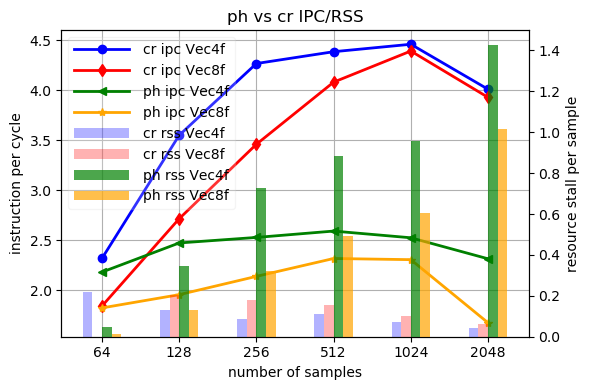

In [39]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                  

ax2.bar(x1, crf_rss4+crb_rss4, width=bar_width, color='blue', alpha=0.3,label='cr rss Vec4f')
ax2.bar(x2, crf_rss8+crb_rss8, width=bar_width, color='red', alpha=0.3, label='cr rss Vec8f')
ax2.bar(x3, ps_rss4+hs_rss4, width=bar_width, color='green', alpha=0.7,label='ph rss Vec4f')
ax2.bar(x4, ps_rss8+hs_rss8, width=bar_width, color='orange', alpha=0.7, label='ph rss Vec8f')
ax1.plot(x, crf_ipc4+crb_ipc4, color='blue', marker='o', linewidth=2, label='cr ipc Vec4f')
ax1.plot(x, crf_ipc8+crb_ipc8, color='red', marker='d', linewidth=2, label='cr ipc Vec8f')
ax1.plot(x, ps_ipc4+hs_ipc4, color='green', marker='<', linewidth=2, label='ph ipc Vec4f')
ax1.plot(x, ps_ipc8+hs_ipc8, color='orange', marker='*', linewidth=2, label='ph ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('ph vs cr IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

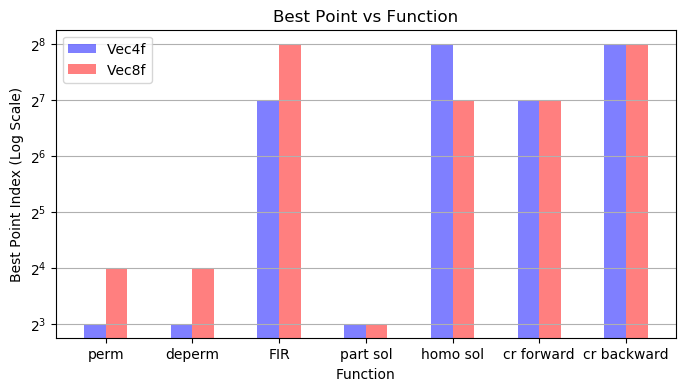

In [40]:
function = ['perm','deperm','FIR','part sol','homo sol','cr forward','cr backward']
best_point4 = 4*2**(np.array([np.argmin(pm_cps4),
              np.argmin(depm_cps4),
              np.argmin(fir_cps4),
              np.argmin(ps_cps4),
              np.argmin(hs_cps4),
              np.argmin(crf_cps4),
              np.argmin(crb_cps4)])+1)

best_point8 = 4*2**(np.array([np.argmin(pm_cps8),
              np.argmin(depm_cps8),
              np.argmin(fir_cps8),
              np.argmin(ps_cps8),
              np.argmin(hs_cps8),
              np.argmin(crf_cps8),
              np.argmin(crb_cps8)])+1)

bar_width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

x_fun = np.arange(len(function))
x1 = x_fun - bar_width / 2
x2 = x_fun + bar_width / 2

ax.bar(x1, best_point4, width=bar_width, color='blue', alpha=0.5, label='Vec4f')
ax.bar(x2, best_point8, width=bar_width, color='red', alpha=0.5, label='Vec8f')

ax.set_yscale('log', basey=2)
ax.set_xlabel('Function')
ax.set_ylabel('Best Point Index (Log Scale)')
ax.set_title('Best Point vs Function')
ax.set_xticks(x_fun)
ax.set_xticklabels(function)
ax.legend()
ax.grid(axis='y')

plt.show()

Filter PH second order
- 2**17 = 131072 samples
    - cut down 10000/10 = 1000 measurements due to very long measurement 

In [41]:
def remove_large_sample_key(data):
    """Remove 512 from all [function][8] and 1024 from all [function][4]"""
    for function_name in data:
        # Remove 512 from [function][8] if it exists
        if 8 in data[function_name] and 256 in data[function_name][8]:
            del data[function_name][8][256]
        if 8 in data[function_name] and 512 in data[function_name][8]:
            del data[function_name][8][512]
        
        # Remove 1024 from [function][4] if it exists  
        if 4 in data[function_name] and 512 in data[function_name][4]:
            del data[function_name][4][512]
        if 4 in data[function_name] and 1024 in data[function_name][4]:
            del data[function_name][4][1024]

remove_large_sample_key(agner_pmc)  # or remove_keys_method2(your_data)

In [42]:
f_ph2_pmc8 = agner_pmc['filter ph 2'][8]
f_ph2_pmc4 = dict(list(agner_pmc['filter ph 2'][4].items())[2:])

f_ph2_cps8 = np.array([metrics['cps'] for metrics in f_ph2_pmc8.values()])
f_ph2_cps4 = np.array([metrics['cps'] for metrics in f_ph2_pmc4.values()])

f_ph2_ips8 = np.array([metrics['ips'] for metrics in f_ph2_pmc8.values()])
f_ph2_ips4 = np.array([metrics['ips'] for metrics in f_ph2_pmc4.values()])

f_ph2_ipc8 = np.array([metrics['ipc'] for metrics in f_ph2_pmc8.values()])
f_ph2_ipc4 = np.array([metrics['ipc'] for metrics in f_ph2_pmc4.values()])

f_ph2_rsr8 = np.array([metrics['rsr'] for metrics in f_ph2_pmc8.values()])
f_ph2_rsr4 = np.array([metrics['rsr'] for metrics in f_ph2_pmc4.values()])

f_ph2_rss8 = np.array([metrics['rss'] for metrics in f_ph2_pmc8.values()])
f_ph2_rss4 = np.array([metrics['rss'] for metrics in f_ph2_pmc4.values()])

f_ph2_rs8 = np.array([metrics['resource stall'] for metrics in f_ph2_pmc8.values()])
f_ph2_rs4 = np.array([metrics['resource stall'] for metrics in f_ph2_pmc4.values()])

x = x[:-1]
sample_len = sample_len[:-1]

In [43]:
ph_pmc8 = agner_pmc['iir ph'][8]
ph_pmc4 = dict(list(agner_pmc['iir ph'][4].items())[2:])

ph_cps8 = np.array([metrics['cps'] for metrics in ph_pmc8.values()])
ph_cps4 = np.array([metrics['cps'] for metrics in ph_pmc4.values()])

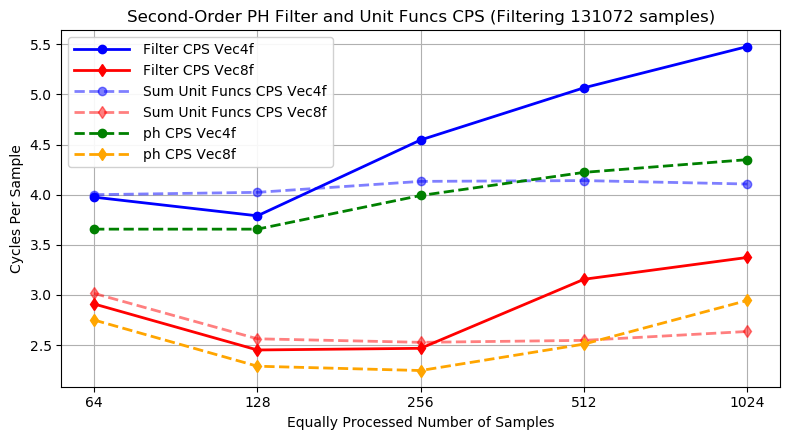

In [44]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter cps
ax.plot(x, f_ph2_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_ph2_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions cps
ax.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + ps_cps4 + hs_cps4)[:-1], '--o', label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + ps_cps8 + hs_cps8)[:-1], '--d', label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

ax.plot(x, ph_cps4, '--o', label='ph CPS Vec4f', color='green', linewidth=2)
ax.plot(x, ph_cps8, '--d', label='ph CPS Vec8f', color='orange', linewidth=2)

ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('Second-Order PH Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


basically it follows the same trend. The difference is caused by incremented resource stall if filtering large pieces of samples.

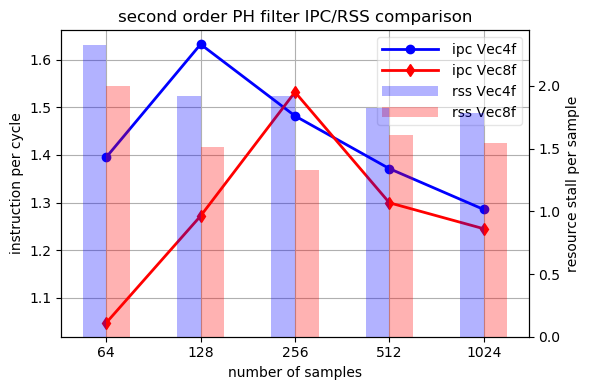

In [45]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, f_ph2_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, f_ph2_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, f_ph2_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, f_ph2_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('second order PH filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Filter CR second order

In [46]:
f_cr2_pmc8 = agner_pmc['filter cr 2'][8]
f_cr2_pmc4 = dict(list(agner_pmc['filter cr 2'][4].items())[2:])

f_cr2_cps8 = np.array([metrics['cps'] for metrics in f_cr2_pmc8.values()])
f_cr2_cps4 = np.array([metrics['cps'] for metrics in f_cr2_pmc4.values()])

f_cr2_ips8 = np.array([metrics['ips'] for metrics in f_cr2_pmc8.values()])
f_cr2_ips4 = np.array([metrics['ips'] for metrics in f_cr2_pmc4.values()])

f_cr2_ipc8 = np.array([metrics['ipc'] for metrics in f_cr2_pmc8.values()])
f_cr2_ipc4 = np.array([metrics['ipc'] for metrics in f_cr2_pmc4.values()])

f_cr2_rsr8 = np.array([metrics['rsr'] for metrics in f_cr2_pmc8.values()])
f_cr2_rsr4 = np.array([metrics['rsr'] for metrics in f_cr2_pmc4.values()])

f_cr2_rss8 = np.array([metrics['rss'] for metrics in f_cr2_pmc8.values()])
f_cr2_rss4 = np.array([metrics['rss'] for metrics in f_cr2_pmc4.values()])

f_cr2_rs8 = np.array([metrics['resource stall'] for metrics in f_cr2_pmc8.values()])
f_cr2_rs4 = np.array([metrics['resource stall'] for metrics in f_cr2_pmc4.values()])

In [47]:
cr_pmc8 = agner_pmc['iir cr'][8]
cr_pmc4 = dict(list(agner_pmc['iir cr'][4].items())[2:])

cr_cps8 = np.array([metrics['cps'] for metrics in cr_pmc8.values()])
cr_cps4 = np.array([metrics['cps'] for metrics in cr_pmc4.values()])

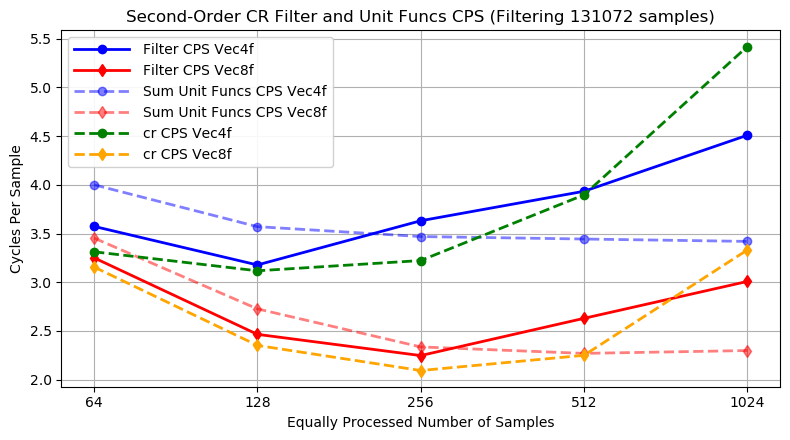

In [48]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter cps
ax.plot(x, f_cr2_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_cr2_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions cps
ax.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + crf_cps4 + crb_cps4)[:-1], '--o',
        label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + crf_cps8 + crb_cps8)[:-1], '--d',
        label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

ax.plot(x, cr_cps4, '--o', label='cr CPS Vec4f', color='green', linewidth=2)
ax.plot(x, cr_cps8, '--d', label='cr CPS Vec8f', color='orange', linewidth=2)

# Labeling and grid
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('Second-Order CR Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


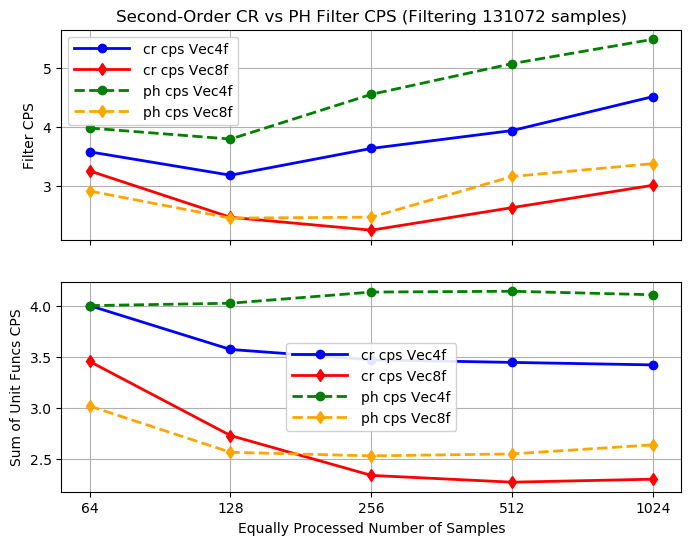

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_cr2_cps4, '-o', label='cr cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_cr2_cps8, '-d', label='cr cps Vec8f', color='red', linewidth=2)
ax1.plot(x, f_ph2_cps4, '--o', label='ph cps Vec4f', color='green', linewidth=2)
ax1.plot(x, f_ph2_cps8, '--d', label='ph cps Vec8f', color='orange', linewidth=2)
ax1.set_ylabel('Filter CPS')
ax1.set_title('Second-Order CR vs PH Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + crf_cps4 + crb_cps4)[:-1], '-o', label='cr cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + crf_cps8 + crb_cps8)[:-1], '-d', label='cr cps Vec8f', color='red', linewidth=2)
ax2.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + ps_cps4 + hs_cps4)[:-1], '--o', label='ph cps Vec4f', color='green', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + ps_cps8 + hs_cps8)[:-1], '--d', label='ph cps Vec8f', color='orange', linewidth=2)
ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('Equally Processed Number of Samples')
ax2.set_ylabel('Sum of Unit Funcs CPS')
ax2.grid(True)
ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.show()


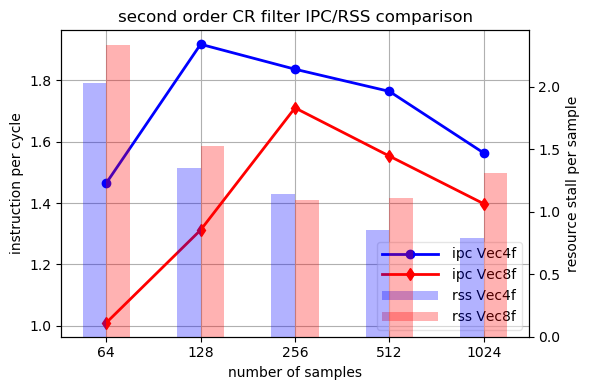

In [50]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, f_cr2_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, f_cr2_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, f_cr2_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, f_cr2_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('second order CR filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Filter PH second order

In [51]:
f_ph4_pmc8 = agner_pmc['filter ph 4'][8]
f_ph4_pmc4 = dict(list(agner_pmc['filter ph 4'][4].items())[2:])

f_ph4_cps8 = np.array([metrics['cps'] for metrics in f_ph4_pmc8.values()])
f_ph4_cps4 = np.array([metrics['cps'] for metrics in f_ph4_pmc4.values()])

f_ph4_ips8 = np.array([metrics['ips'] for metrics in f_ph4_pmc8.values()])
f_ph4_ips4 = np.array([metrics['ips'] for metrics in f_ph4_pmc4.values()])

f_ph4_ipc8 = np.array([metrics['ipc'] for metrics in f_ph4_pmc8.values()])
f_ph4_ipc4 = np.array([metrics['ipc'] for metrics in f_ph4_pmc4.values()])

f_ph4_rsr8 = np.array([metrics['rsr'] for metrics in f_ph4_pmc8.values()])
f_ph4_rsr4 = np.array([metrics['rsr'] for metrics in f_ph4_pmc4.values()])

f_ph4_rss8 = np.array([metrics['rss'] for metrics in f_ph4_pmc8.values()])
f_ph4_rss4 = np.array([metrics['rss'] for metrics in f_ph4_pmc4.values()])

f_ph4_rs8 = np.array([metrics['resource stall'] for metrics in f_ph4_pmc8.values()])
f_ph4_rs4 = np.array([metrics['resource stall'] for metrics in f_ph4_pmc4.values()])

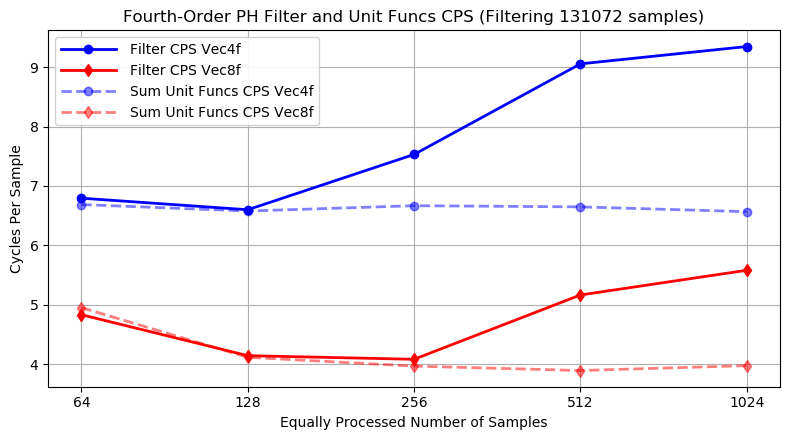

In [52]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter cps
ax.plot(x, f_ph4_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_ph4_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions cps
ax.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + ps_cps4 + hs_cps4))[:-1], '--o',
        label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + ps_cps8 + hs_cps8))[:-1], '--d',
        label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

# Axes and labels
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('Fourth-Order PH Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


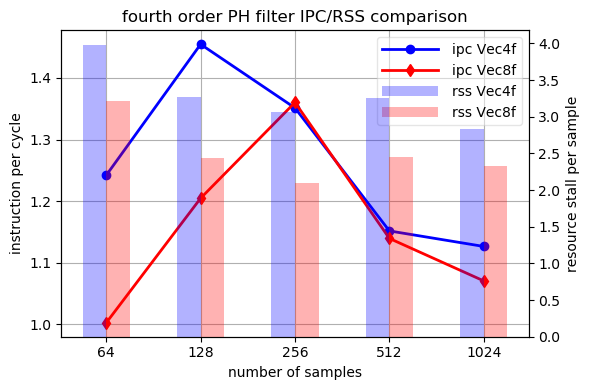

In [53]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - bar_width     
x2 = x + bar_width                   

ax2.bar(x1, f_ph4_rss4, width=bar_width*2, color='blue', alpha=0.3,label='rss Vec4f')
ax2.bar(x2, f_ph4_rss8, width=bar_width*2, color='red', alpha=0.3, label='rss Vec8f')
ax1.plot(x, f_ph4_ipc4, color='blue', marker='o', linewidth=2, label='ipc Vec4f')
ax1.plot(x, f_ph4_ipc8, color='red', marker='d', linewidth=2, label='ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('fourth order PH filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

Filter CR fourth order

In [54]:
f_cr4_pmc8 = agner_pmc['filter cr 4'][8]
f_cr4_pmc4 = dict(list(agner_pmc['filter cr 4'][4].items())[2:])

f_cr4_cps8 = np.array([metrics['cps'] for metrics in f_cr4_pmc8.values()])
f_cr4_cps4 = np.array([metrics['cps'] for metrics in f_cr4_pmc4.values()])

f_cr4_ips8 = np.array([metrics['ips'] for metrics in f_cr4_pmc8.values()])
f_cr4_ips4 = np.array([metrics['ips'] for metrics in f_cr4_pmc4.values()])

f_cr4_ipc8 = np.array([metrics['ipc'] for metrics in f_cr4_pmc8.values()])
f_cr4_ipc4 = np.array([metrics['ipc'] for metrics in f_cr4_pmc4.values()])

f_cr4_rsr8 = np.array([metrics['rsr'] for metrics in f_cr4_pmc8.values()])
f_cr4_rsr4 = np.array([metrics['rsr'] for metrics in f_cr4_pmc4.values()])

f_cr4_rss8 = np.array([metrics['rss'] for metrics in f_cr4_pmc8.values()])
f_cr4_rss4 = np.array([metrics['rss'] for metrics in f_cr4_pmc4.values()])

f_cr4_rs8 = np.array([metrics['resource stall'] for metrics in f_cr4_pmc8.values()])
f_cr4_rs4 = np.array([metrics['resource stall'] for metrics in f_cr4_pmc4.values()])

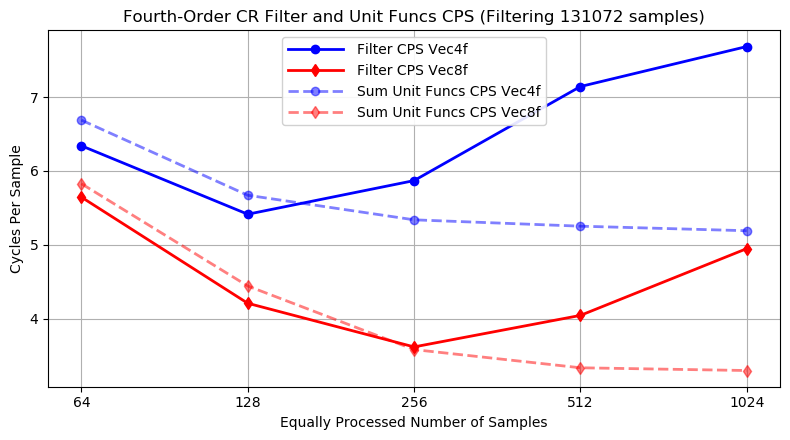

In [55]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter CPS
ax.plot(x, f_cr4_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_cr4_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions CPS
ax.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + crf_cps4 + crb_cps4))[:-1], '--o',
        label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + crf_cps8 + crb_cps8))[:-1], '--d',
        label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('Fourth-Order CR Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


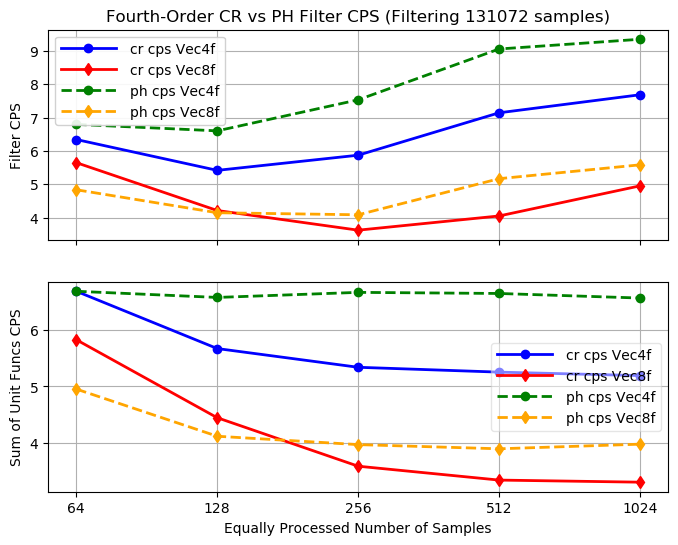

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_cr4_cps4, '-o', label='cr cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_cr4_cps8, '-d', label='cr cps Vec8f', color='red', linewidth=2)
ax1.plot(x, f_ph4_cps4, '--o', label='ph cps Vec4f', color='green', linewidth=2)
ax1.plot(x, f_ph4_cps8, '--d', label='ph cps Vec8f', color='orange', linewidth=2)
ax1.set_ylabel('Filter CPS')
ax1.set_title('Fourth-Order CR vs PH Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + crf_cps4 + crb_cps4))[:-1], '-o', label='cr cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + crf_cps8 + crb_cps8))[:-1], '-d', label='cr cps Vec8f', color='red', linewidth=2)
ax2.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + ps_cps4 + hs_cps4))[:-1], '--o', label='ph cps Vec4f', color='green', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + ps_cps8 + hs_cps8))[:-1], '--d', label='ph cps Vec8f', color='orange', linewidth=2)
ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('Equally Processed Number of Samples')
ax2.set_ylabel('Sum of Unit Funcs CPS')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='center right')
legend.get_frame().set_alpha(0.5)

plt.show()


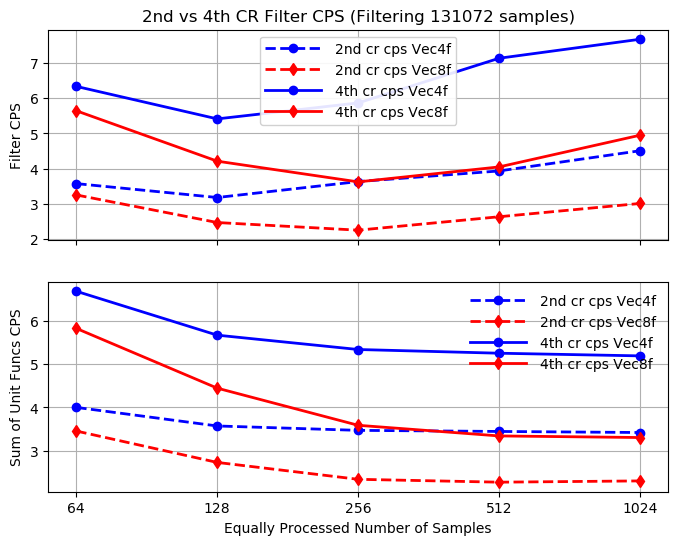

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_cr2_cps4, '--o', label='2nd cr cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_cr2_cps8, '--d', label='2nd cr cps Vec8f', color='red', linewidth=2)

ax1.plot(x, f_cr4_cps4, '-o', label='4th cr cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_cr4_cps8, '-d', label='4th cr cps Vec8f', color='red', linewidth=2)

ax1.set_ylabel('Filter CPS')
ax1.set_title('2nd vs 4th CR Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + crf_cps4 + crb_cps4)[:-1], '--o', label='2nd cr cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + crf_cps8 + crb_cps8)[:-1], '--d', label='2nd cr cps Vec8f', color='red', linewidth=2)

ax2.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + crf_cps4 + crb_cps4))[:-1], '-o', label='4th cr cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + crf_cps8 + crb_cps8))[:-1], '-d', label='4th cr cps Vec8f', color='red', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('Equally Processed Number of Samples')
ax2.set_ylabel('Sum of Unit Funcs CPS')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


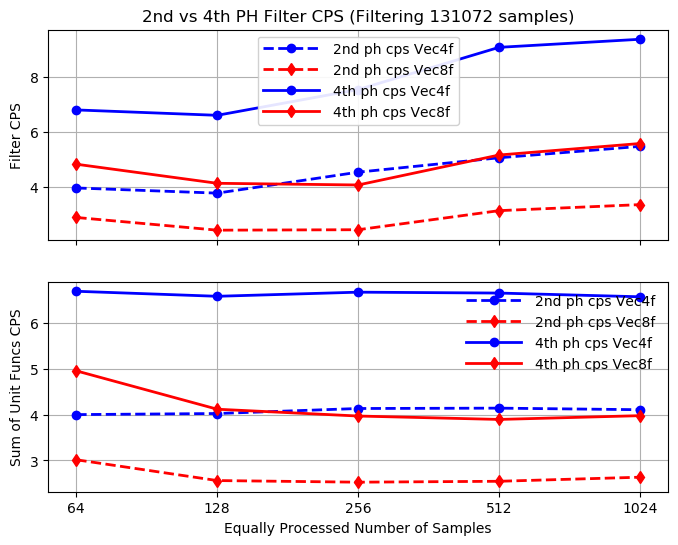

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_ph2_cps4, '--o', label='2nd ph cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_ph2_cps8, '--d', label='2nd ph cps Vec8f', color='red', linewidth=2)

ax1.plot(x, f_ph4_cps4, '-o', label='4th ph cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_ph4_cps8, '-d', label='4th ph cps Vec8f', color='red', linewidth=2)
ax1.set_ylabel('Filter CPS')
ax1.set_title('2nd vs 4th PH Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, (pm_cps4 + depm_cps4 + fir_cps4 + ps_cps4 + hs_cps4)[:-1], '--o', label='2nd ph cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + fir_cps8 + ps_cps8 + hs_cps8)[:-1], '--d', label='2nd ph cps Vec8f', color='red', linewidth=2)

ax2.plot(x, (pm_cps4 + depm_cps4 + 2*(fir_cps4 + ps_cps4 + hs_cps4))[:-1], '-o', label='4th ph cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, (pm_cps8 + depm_cps8 + 2*(fir_cps8 + ps_cps8 + hs_cps8))[:-1], '-d', label='4th ph cps Vec8f', color='red', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('Equally Processed Number of Samples')
ax2.set_ylabel('Sum of Unit Funcs CPS')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


good. equally spaced for all block size.

Filter eighth order and 16th order

In [59]:
f_ph8_pmc8 = agner_pmc['filter ph 8'][8]
f_ph8_pmc4 = dict(list(agner_pmc['filter ph 8'][4].items())[2:])

f_ph8_cps8 = np.array([metrics['cps'] for metrics in f_ph8_pmc8.values()])
f_ph8_cps4 = np.array([metrics['cps'] for metrics in f_ph8_pmc4.values()])

f_ph8_ips8 = np.array([metrics['ips'] for metrics in f_ph8_pmc8.values()])
f_ph8_ips4 = np.array([metrics['ips'] for metrics in f_ph8_pmc4.values()])

f_ph8_ipc8 = np.array([metrics['ipc'] for metrics in f_ph8_pmc8.values()])
f_ph8_ipc4 = np.array([metrics['ipc'] for metrics in f_ph8_pmc4.values()])

f_ph8_rsr8 = np.array([metrics['rsr'] for metrics in f_ph8_pmc8.values()])
f_ph8_rsr4 = np.array([metrics['rsr'] for metrics in f_ph8_pmc4.values()])

f_ph8_rss8 = np.array([metrics['rss'] for metrics in f_ph8_pmc8.values()])
f_ph8_rss4 = np.array([metrics['rss'] for metrics in f_ph8_pmc4.values()])

f_ph8_rs8 = np.array([metrics['resource stall'] for metrics in f_ph8_pmc8.values()])
f_ph8_rs4 = np.array([metrics['resource stall'] for metrics in f_ph8_pmc4.values()])

In [60]:
f_cr8_pmc8 = agner_pmc['filter cr 8'][8]
f_cr8_pmc4 = dict(list(agner_pmc['filter cr 8'][4].items())[2:])

f_cr8_cps8 = np.array([metrics['cps'] for metrics in f_cr8_pmc8.values()])
f_cr8_cps4 = np.array([metrics['cps'] for metrics in f_cr8_pmc4.values()])

f_cr8_ips8 = np.array([metrics['ips'] for metrics in f_cr8_pmc8.values()])
f_cr8_ips4 = np.array([metrics['ips'] for metrics in f_cr8_pmc4.values()])

f_cr8_ipc8 = np.array([metrics['ipc'] for metrics in f_cr8_pmc8.values()])
f_cr8_ipc4 = np.array([metrics['ipc'] for metrics in f_cr8_pmc4.values()])

f_cr8_rsr8 = np.array([metrics['rsr'] for metrics in f_cr8_pmc8.values()])
f_cr8_rsr4 = np.array([metrics['rsr'] for metrics in f_cr8_pmc4.values()])

f_cr8_rss8 = np.array([metrics['rss'] for metrics in f_cr8_pmc8.values()])
f_cr8_rss4 = np.array([metrics['rss'] for metrics in f_cr8_pmc4.values()])

f_cr8_rs8 = np.array([metrics['resource stall'] for metrics in f_cr8_pmc8.values()])
f_cr8_rs4 = np.array([metrics['resource stall'] for metrics in f_cr8_pmc4.values()])

In [61]:
f_ph16_pmc8 = agner_pmc['filter ph 16'][8]
f_ph16_pmc4 = dict(list(agner_pmc['filter ph 16'][4].items())[2:])

f_ph16_cps8 = np.array([metrics['cps'] for metrics in f_ph16_pmc8.values()])
f_ph16_cps4 = np.array([metrics['cps'] for metrics in f_ph16_pmc4.values()])

f_ph16_ips8 = np.array([metrics['ips'] for metrics in f_ph16_pmc8.values()])
f_ph16_ips4 = np.array([metrics['ips'] for metrics in f_ph16_pmc4.values()])

f_ph16_ipc8 = np.array([metrics['ipc'] for metrics in f_ph16_pmc8.values()])
f_ph16_ipc4 = np.array([metrics['ipc'] for metrics in f_ph16_pmc4.values()])

f_ph16_rsr8 = np.array([metrics['rsr'] for metrics in f_ph16_pmc8.values()])
f_ph16_rsr4 = np.array([metrics['rsr'] for metrics in f_ph16_pmc4.values()])

f_ph16_rss8 = np.array([metrics['rss'] for metrics in f_ph16_pmc8.values()])
f_ph16_rss4 = np.array([metrics['rss'] for metrics in f_ph16_pmc4.values()])

f_ph16_rs8 = np.array([metrics['resource stall'] for metrics in f_ph16_pmc8.values()])
f_ph16_rs4 = np.array([metrics['resource stall'] for metrics in f_ph16_pmc4.values()])

In [62]:
f_cr16_pmc8 = agner_pmc['filter cr 16'][8]
f_cr16_pmc4 = dict(list(agner_pmc['filter cr 16'][4].items())[2:])

f_cr16_cps8 = np.array([metrics['cps'] for metrics in f_cr16_pmc8.values()])
f_cr16_cps4 = np.array([metrics['cps'] for metrics in f_cr16_pmc4.values()])

f_cr16_ips8 = np.array([metrics['ips'] for metrics in f_cr16_pmc8.values()])
f_cr16_ips4 = np.array([metrics['ips'] for metrics in f_cr16_pmc4.values()])

f_cr16_ipc8 = np.array([metrics['ipc'] for metrics in f_cr16_pmc8.values()])
f_cr16_ipc4 = np.array([metrics['ipc'] for metrics in f_cr16_pmc4.values()])

f_cr16_rsr8 = np.array([metrics['rsr'] for metrics in f_cr16_pmc8.values()])
f_cr16_rsr4 = np.array([metrics['rsr'] for metrics in f_cr16_pmc4.values()])

f_cr16_rss8 = np.array([metrics['rss'] for metrics in f_cr16_pmc8.values()])
f_cr16_rss4 = np.array([metrics['rss'] for metrics in f_cr16_pmc4.values()])

f_cr16_rs8 = np.array([metrics['resource stall'] for metrics in f_cr16_pmc8.values()])
f_cr16_rs4 = np.array([metrics['resource stall'] for metrics in f_cr16_pmc4.values()])

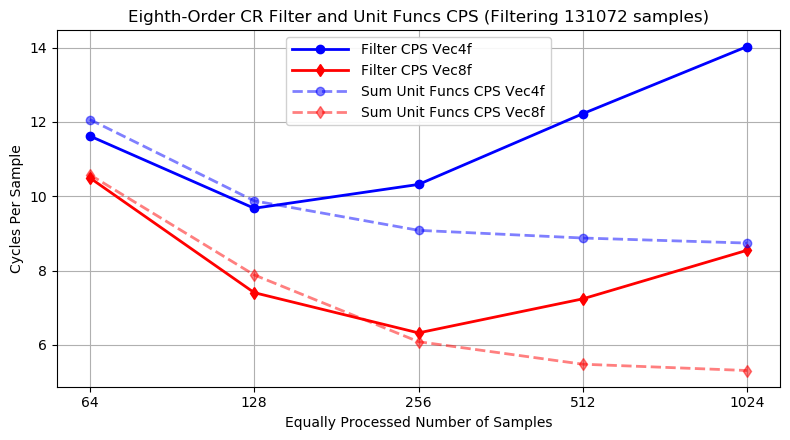

In [63]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter CPS
ax.plot(x, f_cr8_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_cr8_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions CPS
ax.plot(x, (pm_cps4 + depm_cps4 + 4*(fir_cps4 + crf_cps4 + crb_cps4))[:-1], '--o',
        label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + 4*(fir_cps8 + crf_cps8 + crb_cps8))[:-1], '--d',
        label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('Eighth-Order CR Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


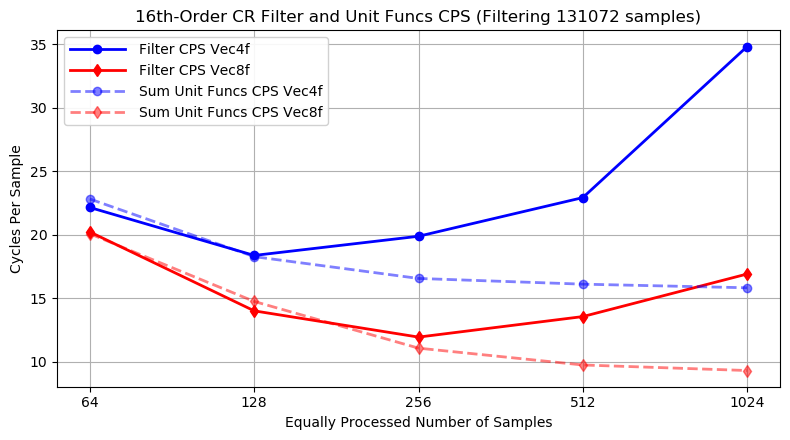

In [64]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot filter CPS
ax.plot(x, f_cr16_cps4, '-o', label='Filter CPS Vec4f', color='blue', linewidth=2)
ax.plot(x, f_cr16_cps8, '-d', label='Filter CPS Vec8f', color='red', linewidth=2)

# Plot sum of unit functions CPS
ax.plot(x, (pm_cps4 + depm_cps4 + 8*(fir_cps4 + crf_cps4 + crb_cps4))[:-1], '--o',
        label='Sum Unit Funcs CPS Vec4f', color='blue', linewidth=2, alpha=0.5)
ax.plot(x, (pm_cps8 + depm_cps8 + 8*(fir_cps8 + crf_cps8 + crb_cps8))[:-1], '--d',
        label='Sum Unit Funcs CPS Vec8f', color='red', linewidth=2, alpha=0.5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Equally Processed Number of Samples')
ax.set_ylabel('Cycles Per Sample')
ax.set_title('16th-Order CR Filter and Unit Funcs CPS (Filtering 131072 samples)')
ax.grid(True)
ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)

plt.tight_layout()
plt.show()


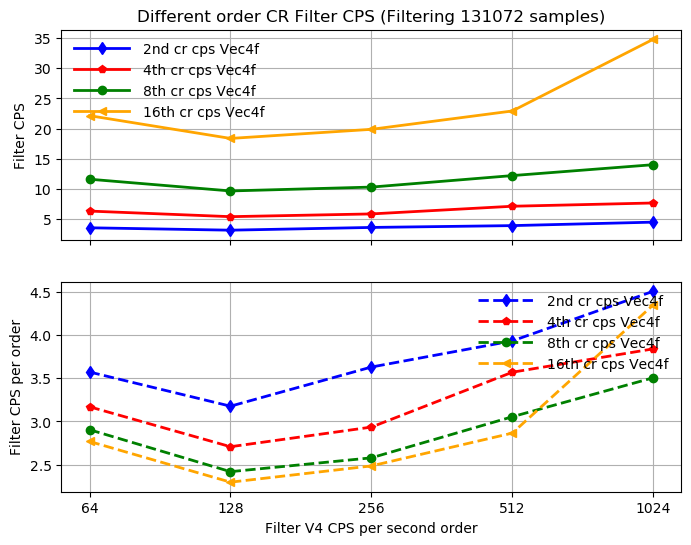

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_cr2_cps4, '-d', label='2nd cr cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_cr4_cps4, '-p', label='4th cr cps Vec4f', color='red', linewidth=2)
ax1.plot(x, f_cr8_cps4, '-o', label='8th cr cps Vec4f', color='green', linewidth=2)
ax1.plot(x, f_cr16_cps4, '-<', label='16th cr cps Vec4f', color='orange', linewidth=2)

ax1.set_ylabel('Filter CPS')
ax1.set_title('Different order CR Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
legend = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.0)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, f_cr2_cps4, '--d', label='2nd cr cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, f_cr4_cps4/2, '--p', label='4th cr cps Vec4f', color='red', linewidth=2)
ax2.plot(x, f_cr8_cps4/4, '--o', label='8th cr cps Vec4f', color='green', linewidth=2)
ax2.plot(x, f_cr16_cps4/8, '--<', label='16th cr cps Vec4f', color='orange', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)

ax2.set_xlabel('Filter V4 CPS per second order')
ax2.set_ylabel('Filter CPS per order')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


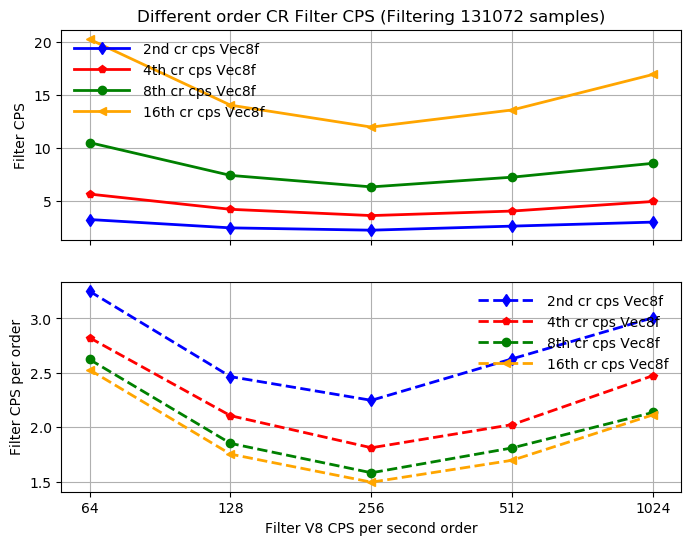

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_cr2_cps8, '-d', label='2nd cr cps Vec8f', color='blue', linewidth=2)
ax1.plot(x, f_cr4_cps8, '-p', label='4th cr cps Vec8f', color='red', linewidth=2)
ax1.plot(x, f_cr8_cps8, '-o', label='8th cr cps Vec8f', color='green', linewidth=2)
ax1.plot(x, f_cr16_cps8, '-<', label='16th cr cps Vec8f', color='orange', linewidth=2)

ax1.set_ylabel('Filter CPS')
ax1.set_title('Different order CR Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
legend = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.0)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, f_cr2_cps8, '--d', label='2nd cr cps Vec8f', color='blue', linewidth=2)
ax2.plot(x, f_cr4_cps8/2, '--p', label='4th cr cps Vec8f', color='red', linewidth=2)
ax2.plot(x, f_cr8_cps8/4, '--o', label='8th cr cps Vec8f', color='green', linewidth=2)
ax2.plot(x, f_cr16_cps8/8, '--<', label='16th cr cps Vec8f', color='orange', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)

ax2.set_xlabel('Filter V8 CPS per second order')
ax2.set_ylabel('Filter CPS per order')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


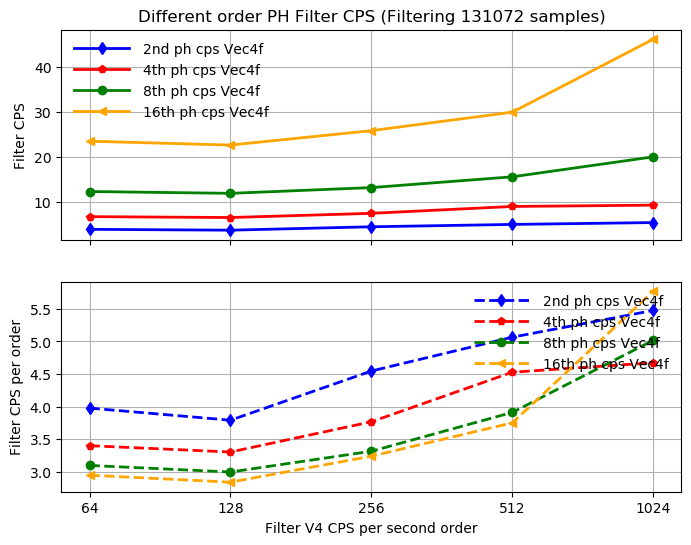

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_ph2_cps4, '-d', label='2nd ph cps Vec4f', color='blue', linewidth=2)
ax1.plot(x, f_ph4_cps4, '-p', label='4th ph cps Vec4f', color='red', linewidth=2)
ax1.plot(x, f_ph8_cps4, '-o', label='8th ph cps Vec4f', color='green', linewidth=2)
ax1.plot(x, f_ph16_cps4, '-<', label='16th ph cps Vec4f', color='orange', linewidth=2)

ax1.set_ylabel('Filter CPS')
ax1.set_title('Different order PH Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
legend = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.0)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, f_ph2_cps4, '--d', label='2nd ph cps Vec4f', color='blue', linewidth=2)
ax2.plot(x, f_ph4_cps4/2, '--p', label='4th ph cps Vec4f', color='red', linewidth=2)
ax2.plot(x, f_ph8_cps4/4, '--o', label='8th ph cps Vec4f', color='green', linewidth=2)
ax2.plot(x, f_ph16_cps4/8, '--<', label='16th ph cps Vec4f', color='orange', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)

ax2.set_xlabel('Filter V4 CPS per second order')
ax2.set_ylabel('Filter CPS per order')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


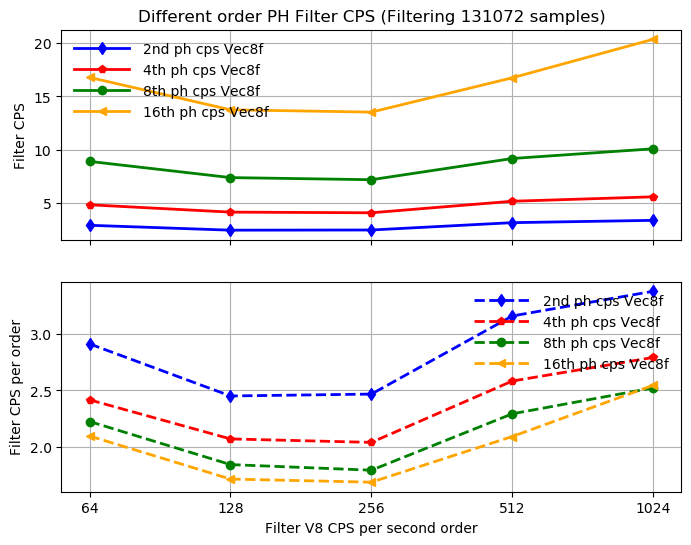

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: filter cps
ax1.plot(x, f_ph2_cps8, '-d', label='2nd ph cps Vec8f', color='blue', linewidth=2)
ax1.plot(x, f_ph4_cps8, '-p', label='4th ph cps Vec8f', color='red', linewidth=2)
ax1.plot(x, f_ph8_cps8, '-o', label='8th ph cps Vec8f', color='green', linewidth=2)
ax1.plot(x, f_ph16_cps8, '-<', label='16th ph cps Vec8f', color='orange', linewidth=2)

ax1.set_ylabel('Filter CPS')
ax1.set_title('Different order PH Filter CPS (Filtering 131072 samples)')
ax1.grid(True)
legend = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper left')
legend.get_frame().set_alpha(0.0)

# Bottom subplot: sum of unit functions cps
ax2.plot(x, f_ph2_cps8, '--d', label='2nd ph cps Vec8f', color='blue', linewidth=2)
ax2.plot(x, f_ph4_cps8/2, '--p', label='4th ph cps Vec8f', color='red', linewidth=2)
ax2.plot(x, f_ph8_cps8/4, '--o', label='8th ph cps Vec8f', color='green', linewidth=2)
ax2.plot(x, f_ph16_cps8/8, '--<', label='16th ph cps Vec8f', color='orange', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)

ax2.set_xlabel('Filter V8 CPS per second order')
ax2.set_ylabel('Filter CPS per order')
ax2.grid(True)
legend=ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.0)

plt.show()


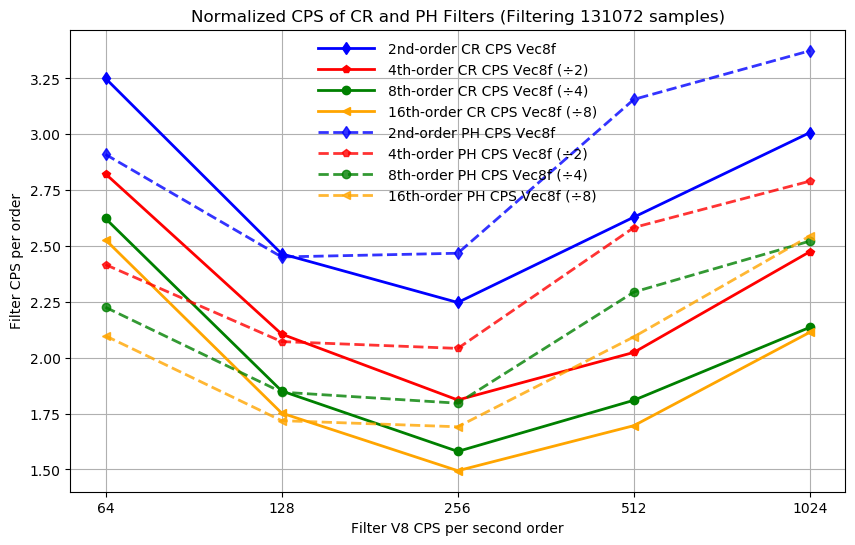

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

# Top (solid lines): CR filter CPS normalized
ax.plot(x, f_cr2_cps8, '-d', label='2nd-order CR CPS Vec8f', color='blue', linewidth=2)
ax.plot(x, f_cr4_cps8 / 2, '-p', label='4th-order CR CPS Vec8f (÷2)', color='red', linewidth=2)
ax.plot(x, f_cr8_cps8 / 4, '-o', label='8th-order CR CPS Vec8f (÷4)', color='green', linewidth=2)
ax.plot(x, f_cr16_cps8 / 8, '-<', label='16th-order CR CPS Vec8f (÷8)', color='orange', linewidth=2)

# Bottom (dashed lines): PH filter CPS normalized
ax.plot(x, f_ph2_cps8, '--d', label='2nd-order PH CPS Vec8f', color='blue', linewidth=2, alpha=0.8)
ax.plot(x, f_ph4_cps8 / 2, '--p', label='4th-order PH CPS Vec8f (÷2)', color='red', linewidth=2, alpha=0.8)
ax.plot(x, f_ph8_cps8 / 4, '--o', label='8th-order PH CPS Vec8f (÷4)', color='green', linewidth=2, alpha=0.8)
ax.plot(x, f_ph16_cps8 / 8, '--<', label='16th-order PH CPS Vec8f (÷8)', color='orange', linewidth=2, alpha=0.8)

# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Filter V8 CPS per second order')
ax.set_ylabel('Filter CPS per order')
ax.set_title('Normalized CPS of CR and PH Filters (Filtering 131072 samples)')
ax.grid(True)

# Legend
legend = ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper center')
legend.get_frame().set_alpha(0.0)

plt.show()


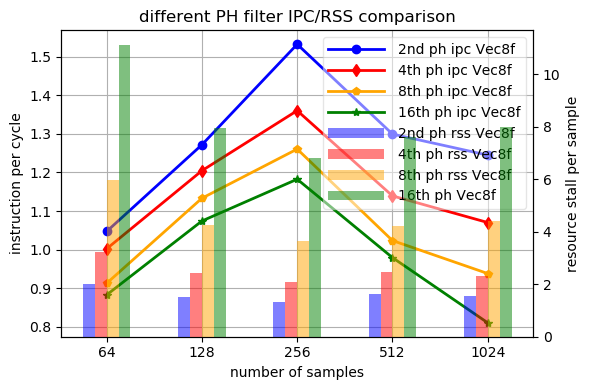

In [70]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                 

ax2.bar(x1, f_ph2_rss8, width=bar_width, color='blue', alpha=0.5,label='2nd ph rss Vec8f')
ax2.bar(x2, f_ph4_rss8, width=bar_width, color='red', alpha=0.5, label='4th ph rss Vec8f')
ax2.bar(x3, f_ph8_rss8, width=bar_width, color='orange', alpha=0.5,label='8th ph rss Vec8f')
ax2.bar(x4, f_ph16_rss8, width=bar_width, color='green', alpha=0.5, label='16th ph Vec8f')

ax1.plot(x, f_ph2_ipc8, color='blue', marker='o', linewidth=2, label='2nd ph ipc Vec8f')
ax1.plot(x, f_ph4_ipc8, color='red', marker='d', linewidth=2, label='4th ph ipc Vec8f')
ax1.plot(x, f_ph8_ipc8, color='orange', marker='p', linewidth=2, label='8th ph ipc Vec8f')
ax1.plot(x, f_ph16_ipc8, color='green', marker='*', linewidth=2, label='16th ph ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('different PH filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

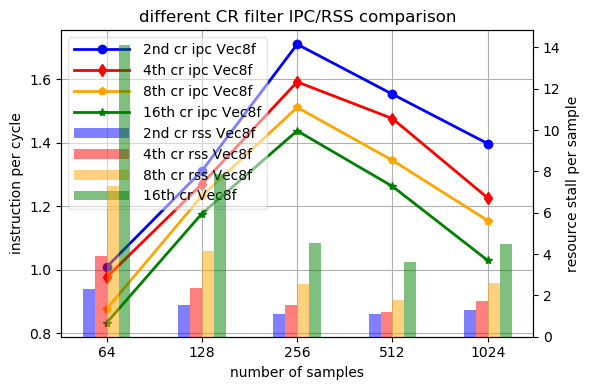

In [71]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                 

ax2.bar(x1, f_cr2_rss8, width=bar_width, color='blue', alpha=0.5,label='2nd cr rss Vec8f')
ax2.bar(x2, f_cr4_rss8, width=bar_width, color='red', alpha=0.5, label='4th cr rss Vec8f')
ax2.bar(x3, f_cr8_rss8, width=bar_width, color='orange', alpha=0.5,label='8th cr rss Vec8f')
ax2.bar(x4, f_cr16_rss8, width=bar_width, color='green', alpha=0.5, label='16th cr Vec8f')

ax1.plot(x, f_cr2_ipc8, color='blue', marker='o', linewidth=2, label='2nd cr ipc Vec8f')
ax1.plot(x, f_cr4_ipc8, color='red', marker='d', linewidth=2, label='4th cr ipc Vec8f')
ax1.plot(x, f_cr8_ipc8, color='orange', marker='p', linewidth=2, label='8th cr ipc Vec8f')
ax1.plot(x, f_cr16_ipc8, color='green', marker='*', linewidth=2, label='16th cr ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('different CR filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

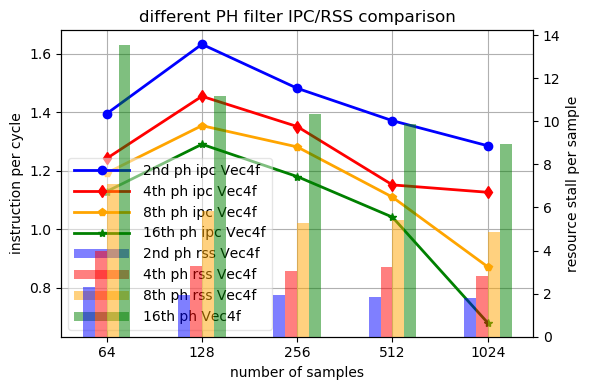

In [72]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                 

ax2.bar(x1, f_ph2_rss4, width=bar_width, color='blue', alpha=0.5,label='2nd ph rss Vec4f')
ax2.bar(x2, f_ph4_rss4, width=bar_width, color='red', alpha=0.5, label='4th ph rss Vec4f')
ax2.bar(x3, f_ph8_rss4, width=bar_width, color='orange', alpha=0.5,label='8th ph rss Vec4f')
ax2.bar(x4, f_ph16_rss4, width=bar_width, color='green', alpha=0.5, label='16th ph Vec4f')

ax1.plot(x, f_ph2_ipc4, color='blue', marker='o', linewidth=2, label='2nd ph ipc Vec4f')
ax1.plot(x, f_ph4_ipc4, color='red', marker='d', linewidth=2, label='4th ph ipc Vec4f')
ax1.plot(x, f_ph8_ipc4, color='orange', marker='p', linewidth=2, label='8th ph ipc Vec4f')
ax1.plot(x, f_ph16_ipc4, color='green', marker='*', linewidth=2, label='16th ph ipc Vec4f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('different PH filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

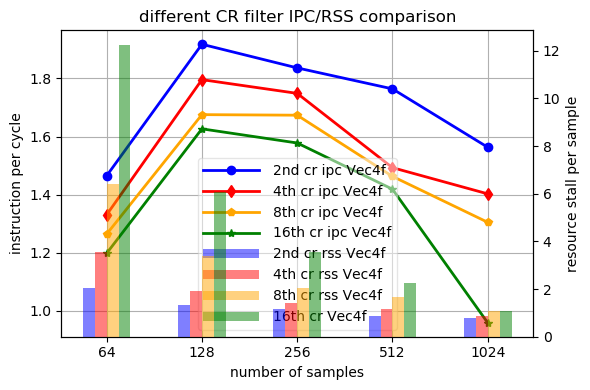

In [73]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                 

ax2.bar(x1, f_cr2_rss4, width=bar_width, color='blue', alpha=0.5,label='2nd cr rss Vec4f')
ax2.bar(x2, f_cr4_rss4, width=bar_width, color='red', alpha=0.5, label='4th cr rss Vec4f')
ax2.bar(x3, f_cr8_rss4, width=bar_width, color='orange', alpha=0.5,label='8th cr rss Vec4f')
ax2.bar(x4, f_cr16_rss4, width=bar_width, color='green', alpha=0.5, label='16th cr Vec4f')

ax1.plot(x, f_cr2_ipc4, color='blue', marker='o', linewidth=2, label='2nd cr ipc Vec4f')
ax1.plot(x, f_cr4_ipc4, color='red', marker='d', linewidth=2, label='4th cr ipc Vec4f')
ax1.plot(x, f_cr8_ipc4, color='orange', marker='p', linewidth=2, label='8th cr ipc Vec4f')
ax1.plot(x, f_cr16_ipc4, color='green', marker='*', linewidth=2, label='16th cr ipc Vec4f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('different CR filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

All good.

Execution time
- 10000 trials and take average

In [74]:
f_ph2_real_pmc8 = agner_pmc['filter ph 2 real'][8]
f_ph2_real_pmc4 = dict(list(agner_pmc['filter ph 2 real'][4].items())[2:])

f_ph2_exp_time8 = np.array([metrics['expected time'] for metrics in f_ph2_real_pmc8.values()])
f_ph2_exp_time4 = np.array([metrics['expected time'] for metrics in f_ph2_real_pmc4.values()])

f_ph2_real_cps8 = np.array([metrics['real cps'] for metrics in f_ph2_real_pmc8.values()])
f_ph2_real_cps4 = np.array([metrics['real cps'] for metrics in f_ph2_real_pmc4.values()])

f_ph2_real_time8 = np.array([metrics['real time'] for metrics in f_ph2_real_pmc8.values()])
f_ph2_real_time4 = np.array([metrics['real time'] for metrics in f_ph2_real_pmc4.values()])

In [75]:
f_ph4_real_pmc8 = agner_pmc['filter ph 4 real'][8]
f_ph4_real_pmc4 = dict(list(agner_pmc['filter ph 4 real'][4].items())[2:])

f_ph4_exp_time8 = np.array([metrics['expected time'] for metrics in f_ph4_real_pmc8.values()])
f_ph4_exp_time4 = np.array([metrics['expected time'] for metrics in f_ph4_real_pmc4.values()])

f_ph4_real_cps8 = np.array([metrics['real cps'] for metrics in f_ph4_real_pmc8.values()])
f_ph4_real_cps4 = np.array([metrics['real cps'] for metrics in f_ph4_real_pmc4.values()])

f_ph4_real_time8 = np.array([metrics['real time'] for metrics in f_ph4_real_pmc8.values()])
f_ph4_real_time4 = np.array([metrics['real time'] for metrics in f_ph4_real_pmc4.values()])

In [76]:
f_ph8_real_pmc8 = agner_pmc['filter ph 8 real'][8]
f_ph8_real_pmc4 = dict(list(agner_pmc['filter ph 8 real'][4].items())[2:])

f_ph8_exp_time8 = np.array([metrics['expected time'] for metrics in f_ph8_real_pmc8.values()])
f_ph8_exp_time4 = np.array([metrics['expected time'] for metrics in f_ph8_real_pmc4.values()])

f_ph8_real_cps8 = np.array([metrics['real cps'] for metrics in f_ph8_real_pmc8.values()])
f_ph8_real_cps4 = np.array([metrics['real cps'] for metrics in f_ph8_real_pmc4.values()])

f_ph8_real_time8 = np.array([metrics['real time'] for metrics in f_ph8_real_pmc8.values()])
f_ph8_real_time4 = np.array([metrics['real time'] for metrics in f_ph8_real_pmc4.values()])

In [77]:
f_ph16_real_pmc8 = agner_pmc['filter ph 16 real'][8]
f_ph16_real_pmc4 = dict(list(agner_pmc['filter ph 16 real'][4].items())[2:])

f_ph16_exp_time8 = np.array([metrics['expected time'] for metrics in f_ph16_real_pmc8.values()])
f_ph16_exp_time4 = np.array([metrics['expected time'] for metrics in f_ph16_real_pmc4.values()])

f_ph16_real_cps8 = np.array([metrics['real cps'] for metrics in f_ph16_real_pmc8.values()])
f_ph16_real_cps4 = np.array([metrics['real cps'] for metrics in f_ph16_real_pmc4.values()])

f_ph16_real_time8 = np.array([metrics['real time'] for metrics in f_ph16_real_pmc8.values()])
f_ph16_real_time4 = np.array([metrics['real time'] for metrics in f_ph16_real_pmc4.values()])

In [78]:
f_cr2_real_pmc8 = agner_pmc['filter cr 2 real'][8]
f_cr2_real_pmc4 = dict(list(agner_pmc['filter cr 2 real'][4].items())[2:])

f_cr2_exp_time8 = np.array([metrics['expected time'] for metrics in f_cr2_real_pmc8.values()])
f_cr2_exp_time4 = np.array([metrics['expected time'] for metrics in f_cr2_real_pmc4.values()])

f_cr2_real_cps8 = np.array([metrics['real cps'] for metrics in f_cr2_real_pmc8.values()])
f_cr2_real_cps4 = np.array([metrics['real cps'] for metrics in f_cr2_real_pmc4.values()])

f_cr2_real_time8 = np.array([metrics['real time'] for metrics in f_cr2_real_pmc8.values()])
f_cr2_real_time4 = np.array([metrics['real time'] for metrics in f_cr2_real_pmc4.values()])

In [79]:
f_cr4_real_pmc8 = agner_pmc['filter cr 4 real'][8]
f_cr4_real_pmc4 = dict(list(agner_pmc['filter cr 4 real'][4].items())[2:])

f_cr4_exp_time8 = np.array([metrics['expected time'] for metrics in f_cr4_real_pmc8.values()])
f_cr4_exp_time4 = np.array([metrics['expected time'] for metrics in f_cr4_real_pmc4.values()])

f_cr4_real_cps8 = np.array([metrics['real cps'] for metrics in f_cr4_real_pmc8.values()])
f_cr4_real_cps4 = np.array([metrics['real cps'] for metrics in f_cr4_real_pmc4.values()])

f_cr4_real_time8 = np.array([metrics['real time'] for metrics in f_cr4_real_pmc8.values()])
f_cr4_real_time4 = np.array([metrics['real time'] for metrics in f_cr4_real_pmc4.values()])

In [80]:
f_cr8_real_pmc8 = agner_pmc['filter cr 8 real'][8]
f_cr8_real_pmc4 = dict(list(agner_pmc['filter cr 8 real'][4].items())[2:])

f_cr8_exp_time8 = np.array([metrics['expected time'] for metrics in f_cr8_real_pmc8.values()])
f_cr8_exp_time4 = np.array([metrics['expected time'] for metrics in f_cr8_real_pmc4.values()])

f_cr8_real_cps8 = np.array([metrics['real cps'] for metrics in f_cr8_real_pmc8.values()])
f_cr8_real_cps4 = np.array([metrics['real cps'] for metrics in f_cr8_real_pmc4.values()])

f_cr8_real_time8 = np.array([metrics['real time'] for metrics in f_cr8_real_pmc8.values()])
f_cr8_real_time4 = np.array([metrics['real time'] for metrics in f_cr8_real_pmc4.values()])

In [81]:
f_cr16_real_pmc8 = agner_pmc['filter cr 16 real'][8]
f_cr16_real_pmc4 = dict(list(agner_pmc['filter cr 16 real'][4].items())[2:])

f_cr16_exp_time8 = np.array([metrics['expected time'] for metrics in f_cr16_real_pmc8.values()])
f_cr16_exp_time4 = np.array([metrics['expected time'] for metrics in f_cr16_real_pmc4.values()])

f_cr16_real_cps8 = np.array([metrics['real cps'] for metrics in f_cr16_real_pmc8.values()])
f_cr16_real_cps4 = np.array([metrics['real cps'] for metrics in f_cr16_real_pmc4.values()])

f_cr16_real_time8 = np.array([metrics['real time'] for metrics in f_cr16_real_pmc8.values()])
f_cr16_real_time4 = np.array([metrics['real time'] for metrics in f_cr16_real_pmc4.values()])

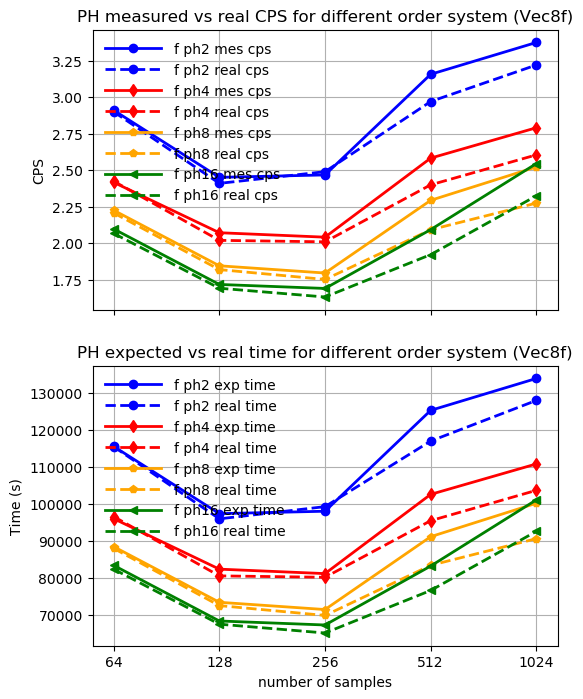

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: CPS ---
ax1.plot(x, f_ph2_cps8, '-o', label='f ph2 mes cps', color='blue', linewidth=2)
ax1.plot(x, f_ph2_real_cps8, '--o', label='f ph2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_ph4_cps8/2, '-d', label='f ph4 mes cps', color='red', linewidth=2)
ax1.plot(x, f_ph4_real_cps8/2, '--d', label='f ph4 real cps', color='red', linewidth=2)

ax1.plot(x, f_ph8_cps8/4, '-p', label='f ph8 mes cps', color='orange', linewidth=2)
ax1.plot(x, f_ph8_real_cps8/4, '--p', label='f ph8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_ph16_cps8/8, '-<', label='f ph16 mes cps', color='green', linewidth=2)
ax1.plot(x, f_ph16_real_cps8/8, '--<', label='f ph16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('PH measured vs real CPS for different order system (Vec8f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Time ---
ax2.plot(x, f_ph2_exp_time8, '-o', label='f ph2 exp time', color='blue', linewidth=2)
ax2.plot(x, f_ph2_real_time8, '--o', label='f ph2 real time', color='blue', linewidth=2)

ax2.plot(x, f_ph4_exp_time8/2, '-d', label='f ph4 exp time', color='red', linewidth=2)
ax2.plot(x, f_ph4_real_time8/2, '--d', label='f ph4 real time', color='red', linewidth=2)

ax2.plot(x, f_ph8_exp_time8/4, '-p', label='f ph8 exp time', color='orange', linewidth=2)
ax2.plot(x, f_ph8_real_time8/4, '--p', label='f ph8 real time', color='orange', linewidth=2)

ax2.plot(x, f_ph16_exp_time8/8, '-<', label='f ph16 exp time', color='green', linewidth=2)
ax2.plot(x, f_ph16_real_time8/8, '--<', label='f ph16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('PH expected vs real time for different order system (Vec8f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.show()


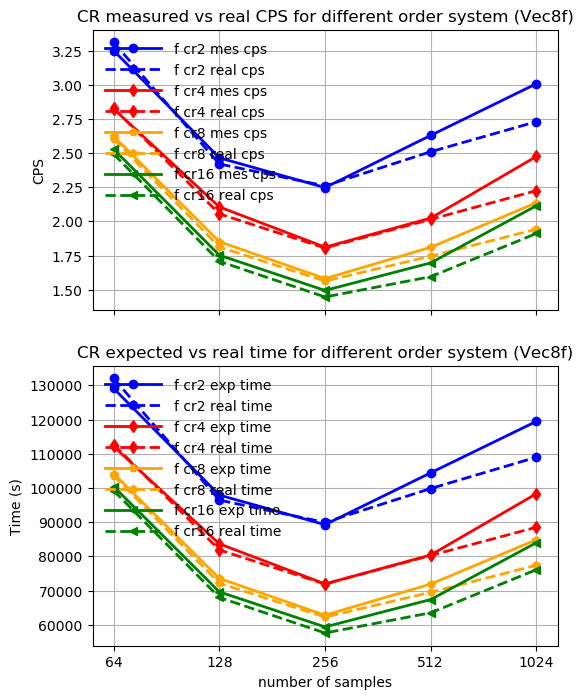

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: CPS ---
ax1.plot(x, f_cr2_cps8, '-o', label='f cr2 mes cps', color='blue', linewidth=2)
ax1.plot(x, f_cr2_real_cps8, '--o', label='f cr2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_cr4_cps8/2, '-d', label='f cr4 mes cps', color='red', linewidth=2)
ax1.plot(x, f_cr4_real_cps8/2, '--d', label='f cr4 real cps', color='red', linewidth=2)

ax1.plot(x, f_cr8_cps8/4, '-p', label='f cr8 mes cps', color='orange', linewidth=2)
ax1.plot(x, f_cr8_real_cps8/4, '--p', label='f cr8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_cr16_cps8/8, '-<', label='f cr16 mes cps', color='green', linewidth=2)
ax1.plot(x, f_cr16_real_cps8/8, '--<', label='f cr16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('CR measured vs real CPS for different order system (Vec8f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Time ---
ax2.plot(x, f_cr2_exp_time8, '-o', label='f cr2 exp time', color='blue', linewidth=2)
ax2.plot(x, f_cr2_real_time8, '--o', label='f cr2 real time', color='blue', linewidth=2)

ax2.plot(x, f_cr4_exp_time8/2, '-d', label='f cr4 exp time', color='red', linewidth=2)
ax2.plot(x, f_cr4_real_time8/2, '--d', label='f cr4 real time', color='red', linewidth=2)

ax2.plot(x, f_cr8_exp_time8/4, '-p', label='f cr8 exp time', color='orange', linewidth=2)
ax2.plot(x, f_cr8_real_time8/4, '--p', label='f cr8 real time', color='orange', linewidth=2)

ax2.plot(x, f_cr16_exp_time8/8, '-<', label='f cr16 exp time', color='green', linewidth=2)
ax2.plot(x, f_cr16_real_time8/8, '--<', label='f cr16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('CR expected vs real time for different order system (Vec8f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.show()


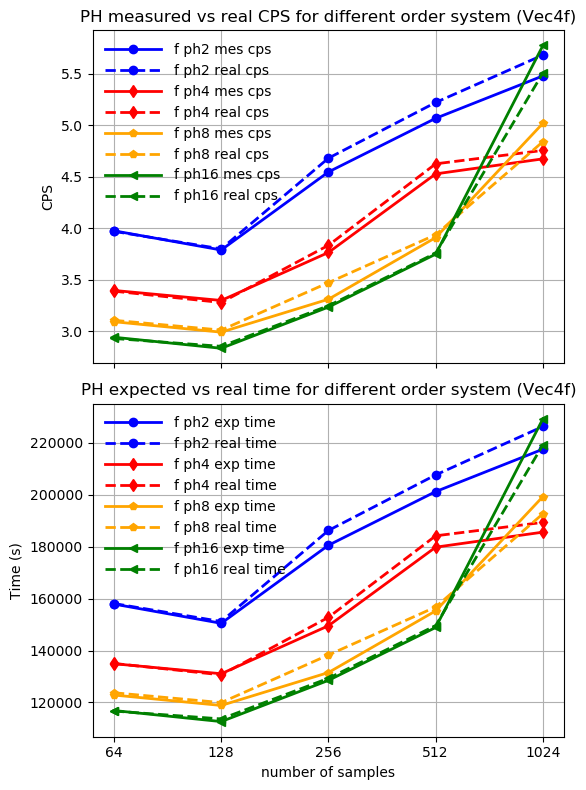

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: CPS ---
ax1.plot(x, f_ph2_cps4, '-o', label='f ph2 mes cps', color='blue', linewidth=2)
ax1.plot(x, f_ph2_real_cps4, '--o', label='f ph2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_ph4_cps4/2, '-d', label='f ph4 mes cps', color='red', linewidth=2)
ax1.plot(x, f_ph4_real_cps4/2, '--d', label='f ph4 real cps', color='red', linewidth=2)

ax1.plot(x, f_ph8_cps4/4, '-p', label='f ph8 mes cps', color='orange', linewidth=2)
ax1.plot(x, f_ph8_real_cps4/4, '--p', label='f ph8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_ph16_cps4/8, '-<', label='f ph16 mes cps', color='green', linewidth=2)
ax1.plot(x, f_ph16_real_cps4/8, '--<', label='f ph16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('PH measured vs real CPS for different order system (Vec4f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Time ---
ax2.plot(x, f_ph2_exp_time4, '-o', label='f ph2 exp time', color='blue', linewidth=2)
ax2.plot(x, f_ph2_real_time4, '--o', label='f ph2 real time', color='blue', linewidth=2)

ax2.plot(x, f_ph4_exp_time4/2, '-d', label='f ph4 exp time', color='red', linewidth=2)
ax2.plot(x, f_ph4_real_time4/2, '--d', label='f ph4 real time', color='red', linewidth=2)

ax2.plot(x, f_ph8_exp_time4/4, '-p', label='f ph8 exp time', color='orange', linewidth=2)
ax2.plot(x, f_ph8_real_time4/4, '--p', label='f ph8 real time', color='orange', linewidth=2)

ax2.plot(x, f_ph16_exp_time4/8, '-<', label='f ph16 exp time', color='green', linewidth=2)
ax2.plot(x, f_ph16_real_time4/8, '--<', label='f ph16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('PH expected vs real time for different order system (Vec4f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.tight_layout()
plt.show()


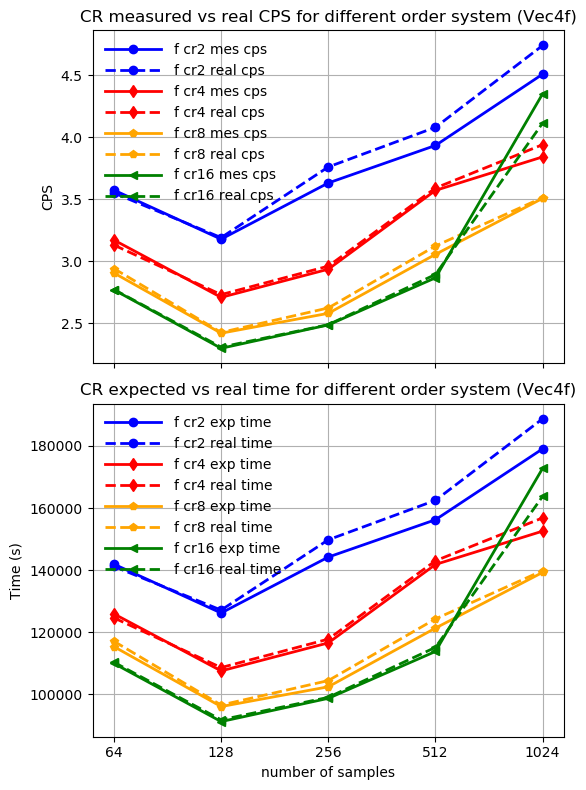

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: CPS ---
ax1.plot(x, f_cr2_cps4, '-o', label='f cr2 mes cps', color='blue', linewidth=2)
ax1.plot(x, f_cr2_real_cps4, '--o', label='f cr2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_cr4_cps4/2, '-d', label='f cr4 mes cps', color='red', linewidth=2)
ax1.plot(x, f_cr4_real_cps4/2, '--d', label='f cr4 real cps', color='red', linewidth=2)

ax1.plot(x, f_cr8_cps4/4, '-p', label='f cr8 mes cps', color='orange', linewidth=2)
ax1.plot(x, f_cr8_real_cps4/4, '--p', label='f cr8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_cr16_cps4/8, '-<', label='f cr16 mes cps', color='green', linewidth=2)
ax1.plot(x, f_cr16_real_cps4/8, '--<', label='f cr16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('CR measured vs real CPS for different order system (Vec4f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Time ---
ax2.plot(x, f_cr2_exp_time4, '-o', label='f cr2 exp time', color='blue', linewidth=2)
ax2.plot(x, f_cr2_real_time4, '--o', label='f cr2 real time', color='blue', linewidth=2)

ax2.plot(x, f_cr4_exp_time4/2, '-d', label='f cr4 exp time', color='red', linewidth=2)
ax2.plot(x, f_cr4_real_time4/2, '--d', label='f cr4 real time', color='red', linewidth=2)

ax2.plot(x, f_cr8_exp_time4/4, '-p', label='f cr8 exp time', color='orange', linewidth=2)
ax2.plot(x, f_cr8_real_time4/4, '--p', label='f cr8 real time', color='orange', linewidth=2)

ax2.plot(x, f_cr16_exp_time4/8, '-<', label='f cr16 exp time', color='green', linewidth=2)
ax2.plot(x, f_cr16_real_time4/8, '--<', label='f cr16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('CR expected vs real time for different order system (Vec4f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.tight_layout()
plt.show()


All good but only CR Vec4f all real performance is much worse than measured performance.

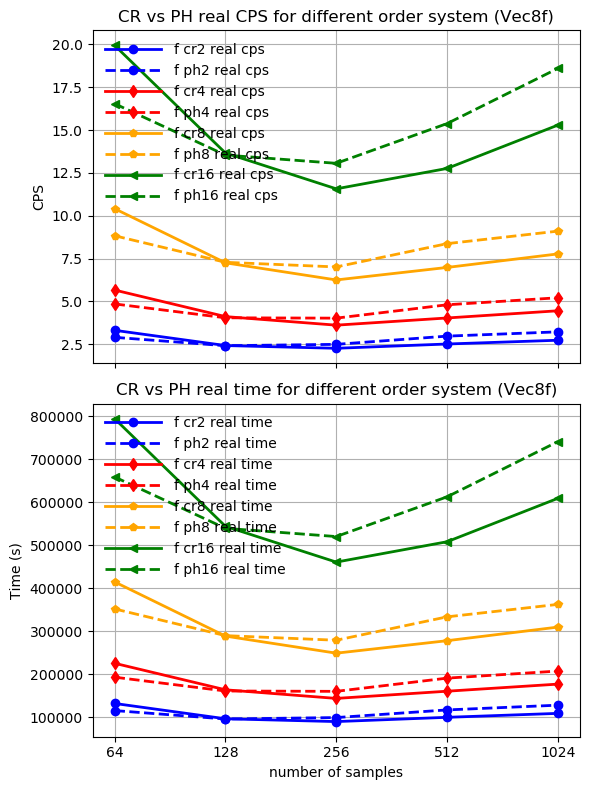

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: Real CPS ---
ax1.plot(x, f_cr2_real_cps8, '-o', label='f cr2 real cps', color='blue', linewidth=2)
ax1.plot(x, f_ph2_real_cps8, '--o', label='f ph2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_cr4_real_cps8, '-d', label='f cr4 real cps', color='red', linewidth=2)
ax1.plot(x, f_ph4_real_cps8, '--d', label='f ph4 real cps', color='red', linewidth=2)

ax1.plot(x, f_cr8_real_cps8, '-p', label='f cr8 real cps', color='orange', linewidth=2)
ax1.plot(x, f_ph8_real_cps8, '--p', label='f ph8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_cr16_real_cps8, '-<', label='f cr16 real cps', color='green', linewidth=2)
ax1.plot(x, f_ph16_real_cps8, '--<', label='f ph16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('CR vs PH real CPS for different order system (Vec8f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Real Time ---
ax2.plot(x, f_cr2_real_time8, '-o', label='f cr2 real time', color='blue', linewidth=2)
ax2.plot(x, f_ph2_real_time8, '--o', label='f ph2 real time', color='blue', linewidth=2)

ax2.plot(x, f_cr4_real_time8, '-d', label='f cr4 real time', color='red', linewidth=2)
ax2.plot(x, f_ph4_real_time8, '--d', label='f ph4 real time', color='red', linewidth=2)

ax2.plot(x, f_cr8_real_time8, '-p', label='f cr8 real time', color='orange', linewidth=2)
ax2.plot(x, f_ph8_real_time8, '--p', label='f ph8 real time', color='orange', linewidth=2)

ax2.plot(x, f_cr16_real_time8, '-<', label='f cr16 real time', color='green', linewidth=2)
ax2.plot(x, f_ph16_real_time8, '--<', label='f ph16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('CR vs PH real time for different order system (Vec8f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.tight_layout()
plt.show()


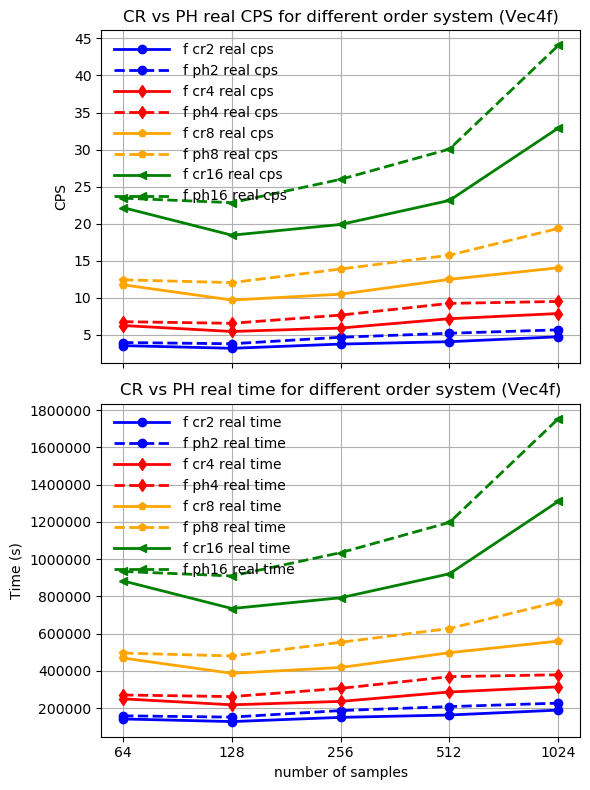

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: Real CPS ---
ax1.plot(x, f_cr2_real_cps4, '-o', label='f cr2 real cps', color='blue', linewidth=2)
ax1.plot(x, f_ph2_real_cps4, '--o', label='f ph2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_cr4_real_cps4, '-d', label='f cr4 real cps', color='red', linewidth=2)
ax1.plot(x, f_ph4_real_cps4, '--d', label='f ph4 real cps', color='red', linewidth=2)

ax1.plot(x, f_cr8_real_cps4, '-p', label='f cr8 real cps', color='orange', linewidth=2)
ax1.plot(x, f_ph8_real_cps4, '--p', label='f ph8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_cr16_real_cps4, '-<', label='f cr16 real cps', color='green', linewidth=2)
ax1.plot(x, f_ph16_real_cps4, '--<', label='f ph16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('CR vs PH real CPS for different order system (Vec4f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Real Time ---
ax2.plot(x, f_cr2_real_time4, '-o', label='f cr2 real time', color='blue', linewidth=2)
ax2.plot(x, f_ph2_real_time4, '--o', label='f ph2 real time', color='blue', linewidth=2)

ax2.plot(x, f_cr4_real_time4, '-d', label='f cr4 real time', color='red', linewidth=2)
ax2.plot(x, f_ph4_real_time4, '--d', label='f ph4 real time', color='red', linewidth=2)

ax2.plot(x, f_cr8_real_time4, '-p', label='f cr8 real time', color='orange', linewidth=2)
ax2.plot(x, f_ph8_real_time4, '--p', label='f ph8 real time', color='orange', linewidth=2)

ax2.plot(x, f_cr16_real_time4, '-<', label='f cr16 real time', color='green', linewidth=2)
ax2.plot(x, f_ph16_real_time4, '--<', label='f ph16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('CR vs PH real time for different order system (Vec4f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.tight_layout()
plt.show()


CR performs better than PH.

Block filtering and Scalar filtering

In [88]:
bf_pmc = agner_pmc['block filtering']
f_bf2_pmc = agner_pmc['filter bf 2']
f_bf4_pmc = agner_pmc['filter bf 4']
f_bf8_pmc = agner_pmc['filter bf 8']
f_bf16_pmc = agner_pmc['filter bf 16']

f_bf2_cps8 = np.array([f_bf2_pmc[8][1]['cps']]*len(x),dtype=float)
f_bf4_cps8 = np.array([f_bf4_pmc[8][1]['cps']]*len(x),dtype=float)
f_bf8_cps8 = np.array([f_bf8_pmc[8][1]['cps']]*len(x),dtype=float)
f_bf16_cps8 = np.array([f_bf16_pmc[8][1]['cps']]*len(x),dtype=float)

f_bf2_cps4 = np.array([f_bf2_pmc[4][1]['cps']]*len(x),dtype=float)
f_bf4_cps4 = np.array([f_bf4_pmc[4][1]['cps']]*len(x),dtype=float)
f_bf8_cps4 = np.array([f_bf8_pmc[4][1]['cps']]*len(x),dtype=float)
f_bf16_cps4 = np.array([f_bf16_pmc[4][1]['cps']]*len(x),dtype=float)

bf_cps8 = np.array([bf_pmc[8][1]['cps']]*len(x),dtype=float)

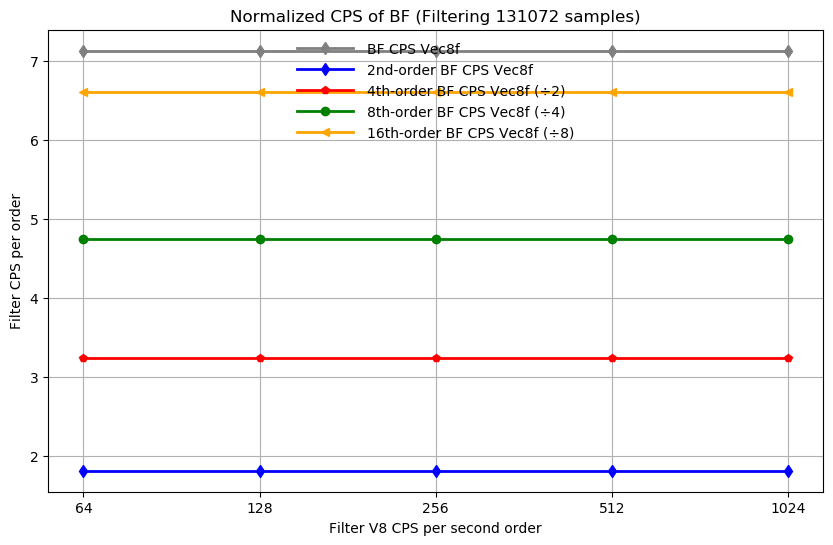

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

# Bottom (dashed lines): PH filter CPS normalized
ax.plot(x, bf_cps8, '-d', label='BF CPS Vec8f', color='gray', linewidth=2)
ax.plot(x, f_bf2_cps8, '-d', label='2nd-order BF CPS Vec8f', color='blue', linewidth=2)
ax.plot(x, f_bf4_cps8 / 2, '-p', label='4th-order BF CPS Vec8f (÷2)', color='red', linewidth=2)
ax.plot(x, f_bf8_cps8 / 4, '-o', label='8th-order BF CPS Vec8f (÷4)', color='green', linewidth=2)
ax.plot(x, f_bf16_cps8 / 8, '-<', label='16th-order BF CPS Vec8f (÷8)', color='orange', linewidth=2)


# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Filter V8 CPS per second order')
ax.set_ylabel('Filter CPS per order')
ax.set_title('Normalized CPS of BF (Filtering 131072 samples)')
ax.grid(True)

# Legend
legend = ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper center')
legend.get_frame().set_alpha(0.0)

plt.show()


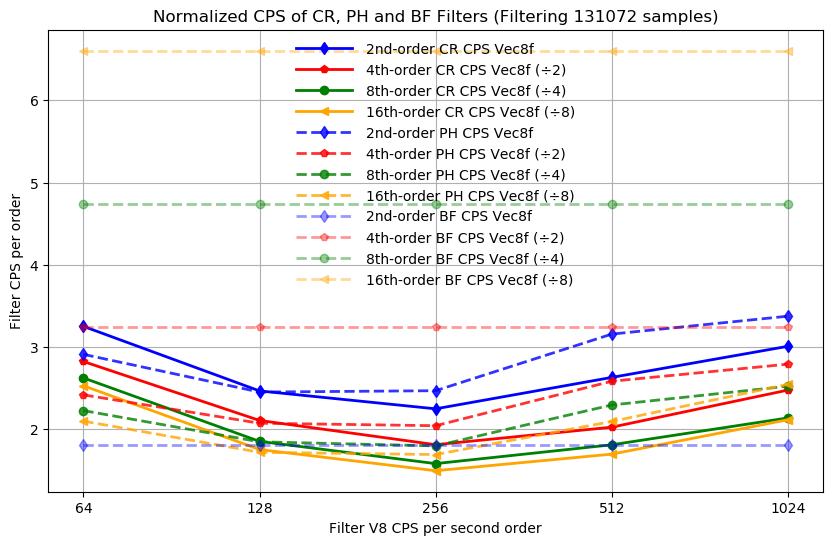

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))

# Top (solid lines): CR filter CPS normalized
ax.plot(x, f_cr2_cps8, '-d', label='2nd-order CR CPS Vec8f', color='blue', linewidth=2)
ax.plot(x, f_cr4_cps8 / 2, '-p', label='4th-order CR CPS Vec8f (÷2)', color='red', linewidth=2)
ax.plot(x, f_cr8_cps8 / 4, '-o', label='8th-order CR CPS Vec8f (÷4)', color='green', linewidth=2)
ax.plot(x, f_cr16_cps8 / 8, '-<', label='16th-order CR CPS Vec8f (÷8)', color='orange', linewidth=2)

# Bottom (dashed lines): PH filter CPS normalized
ax.plot(x, f_ph2_cps8, '--d', label='2nd-order PH CPS Vec8f', color='blue', linewidth=2, alpha=0.8)
ax.plot(x, f_ph4_cps8 / 2, '--p', label='4th-order PH CPS Vec8f (÷2)', color='red', linewidth=2, alpha=0.8)
ax.plot(x, f_ph8_cps8 / 4, '--o', label='8th-order PH CPS Vec8f (÷4)', color='green', linewidth=2, alpha=0.8)
ax.plot(x, f_ph16_cps8 / 8, '--<', label='16th-order PH CPS Vec8f (÷8)', color='orange', linewidth=2, alpha=0.8)

# Bottom (dashed lines): PH filter CPS normalized
ax.plot(x, f_bf2_cps8, '--d', label='2nd-order BF CPS Vec8f', color='blue', linewidth=2, alpha=0.4)
ax.plot(x, f_bf4_cps8 / 2, '--p', label='4th-order BF CPS Vec8f (÷2)', color='red', linewidth=2, alpha=0.4)
ax.plot(x, f_bf8_cps8 / 4, '--o', label='8th-order BF CPS Vec8f (÷4)', color='green', linewidth=2, alpha=0.4)
ax.plot(x, f_bf16_cps8 / 8, '--<', label='16th-order BF CPS Vec8f (÷8)', color='orange', linewidth=2, alpha=0.4)


# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(sample_len)
ax.set_xlabel('Filter V8 CPS per second order')
ax.set_ylabel('Filter CPS per order')
ax.set_title('Normalized CPS of CR, PH and BF Filters (Filtering 131072 samples)')
ax.grid(True)

# Legend
legend = ax.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper center')
legend.get_frame().set_alpha(0.0)

plt.show()


In [91]:
f_bf2_ipc8 = np.array([f_bf2_pmc[8][1]['ipc']]*len(x),dtype=float)
f_bf4_ipc8 = np.array([f_bf4_pmc[8][1]['ipc']]*len(x),dtype=float)
f_bf8_ipc8 = np.array([f_bf8_pmc[8][1]['ipc']]*len(x),dtype=float)
f_bf16_ipc8 = np.array([f_bf16_pmc[8][1]['ipc']]*len(x),dtype=float)

f_bf2_rss8 = np.array([f_bf2_pmc[8][1]['rss']]*len(x),dtype=float)
f_bf4_rss8 = np.array([f_bf4_pmc[8][1]['rss']]*len(x),dtype=float)
f_bf8_rss8 = np.array([f_bf8_pmc[8][1]['rss']]*len(x),dtype=float)
f_bf16_rss8 = np.array([f_bf16_pmc[8][1]['rss']]*len(x),dtype=float)

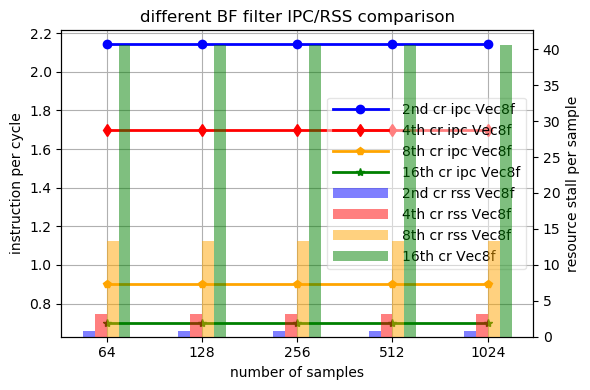

In [92]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x - 1.5*bar_width     
x2 = x - 0.5*bar_width   
x3 = x + 0.5*bar_width     
x4 = x + 1.5*bar_width                 

ax2.bar(x1, f_bf2_rss8, width=bar_width, color='blue', alpha=0.5,label='2nd cr rss Vec8f')
ax2.bar(x2, f_bf4_rss8, width=bar_width, color='red', alpha=0.5, label='4th cr rss Vec8f')
ax2.bar(x3, f_bf8_rss8, width=bar_width, color='orange', alpha=0.5,label='8th cr rss Vec8f')
ax2.bar(x4, f_bf16_rss8, width=bar_width, color='green', alpha=0.5, label='16th cr Vec8f')

ax1.plot(x, f_bf2_ipc8, color='blue', marker='o', linewidth=2, label='2nd cr ipc Vec8f')
ax1.plot(x, f_bf4_ipc8, color='red', marker='d', linewidth=2, label='4th cr ipc Vec8f')
ax1.plot(x, f_bf8_ipc8, color='orange', marker='p', linewidth=2, label='8th cr ipc Vec8f')
ax1.plot(x, f_bf16_ipc8, color='green', marker='*', linewidth=2, label='16th cr ipc Vec8f')

ax1.set_xticks(x)
ax1.set_xticklabels(sample_len)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('different BF filter IPC/RSS comparison')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()

In [93]:
# choose best point of CR and PH at different order and compare with BF
bp = 2 # best point

f_ph_cps_best = np.array([f_ph2_cps8[bp],f_ph4_cps8[bp],f_ph8_cps8[bp],f_ph16_cps8[bp]])
f_cr_cps_best = np.array([f_cr2_cps8[bp],f_cr4_cps8[bp],f_cr8_cps8[bp],f_cr16_cps8[bp]])
f_bf_cps = np.array([f_bf2_pmc[8][1]['cps'],f_bf4_pmc[8][1]['cps'],f_bf8_pmc[8][1]['cps'],f_bf16_pmc[8][1]['cps']])


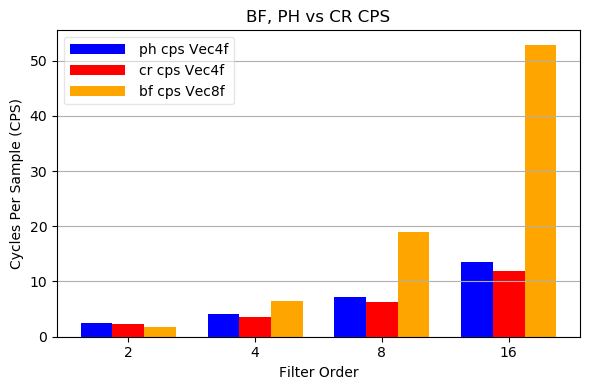

In [94]:
order = [2, 4, 8, 16]
x_order = np.arange(len(order))
bar_width = 0.25

# Shift positions for each bar group
x1 = x_order - bar_width
x2 = x_order
x3 = x_order + bar_width

plt.figure(figsize=(6, 4))

plt.bar(x1, f_ph_cps_best, width=bar_width, label='ph cps Vec4f', color='blue')
plt.bar(x2, f_cr_cps_best, width=bar_width, label='cr cps Vec4f', color='red')
plt.bar(x3, f_bf_cps, width=bar_width, label='bf cps Vec8f', color='orange')

plt.xticks(x_order, order)
plt.title('BF, PH vs CR CPS')
plt.xlabel('Filter Order')
plt.ylabel('Cycles Per Sample (CPS)')
plt.grid(True, axis='y')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()


In [95]:
f_ph_ipc_best = np.array([f_ph2_ipc8[bp],f_ph4_ipc8[bp],f_ph8_ipc8[bp],f_ph16_ipc8[bp]])
f_cr_ipc_best = np.array([f_cr2_ipc8[bp],f_cr4_ipc8[bp],f_cr8_ipc8[bp],f_cr16_ipc8[bp]])
f_bf_ipc = np.array([f_bf2_pmc[8][1]['ipc'],f_bf4_pmc[8][1]['ipc'],f_bf8_pmc[8][1]['ipc'],f_bf16_pmc[8][1]['ipc']])

f_ph_rss_best = np.array([f_ph2_rss8[bp],f_ph4_rss8[bp],f_ph8_rss8[bp],f_ph16_rss8[bp]])
f_cr_rss_best = np.array([f_cr2_rss8[bp],f_cr4_rss8[bp],f_cr8_rss8[bp],f_cr16_rss8[bp]])
f_bf_rss = np.array([f_bf2_pmc[8][1]['rss'],f_bf4_pmc[8][1]['rss'],f_bf8_pmc[8][1]['rss'],f_bf16_pmc[8][1]['rss']])

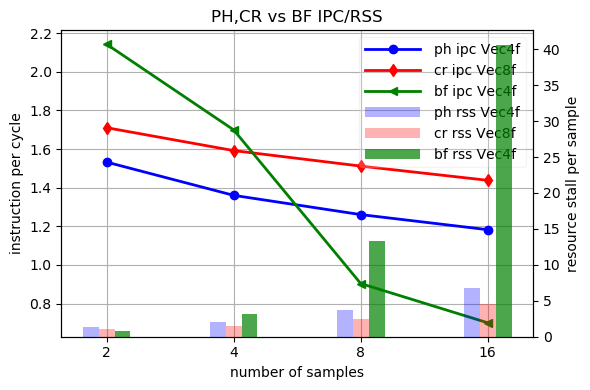

In [108]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x_order - 1*bar_width     
x2 = x_order   
x3 = x_order + 1*bar_width                  

ax2.bar(x1, f_ph_rss_best, width=bar_width, color='blue', alpha=0.3,label='ph rss Vec4f')
ax2.bar(x2, f_cr_rss_best, width=bar_width, color='red', alpha=0.3, label='cr rss Vec8f')
ax2.bar(x3, f_bf_rss, width=bar_width, color='green', alpha=0.7,label='bf rss Vec4f')
ax1.plot(x_order, f_ph_ipc_best, color='blue', marker='o', linewidth=2, label='ph ipc Vec4f')
ax1.plot(x_order, f_cr_ipc_best, color='red', marker='d', linewidth=2, label='cr ipc Vec8f')
ax1.plot(x_order, f_bf_ipc, color='green', marker='<', linewidth=2, label='bf ipc Vec4f')

ax1.set_xticks(x_order)
ax1.set_xticklabels(order)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('PH,CR vs BF IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

In [97]:
f_bf2_real_pmc = agner_pmc['filter bf 2 real']
f_bf4_real_pmc = agner_pmc['filter bf 4 real']
f_bf8_real_pmc = agner_pmc['filter bf 8 real']
f_bf16_real_pmc = agner_pmc['filter bf 16 real']

f_bf2_exp_time8 = np.array([f_bf2_real_pmc[8][1]['expected time']]*len(x),dtype=float)
f_bf4_exp_time8 = np.array([f_bf4_real_pmc[8][1]['expected time']]*len(x),dtype=float)
f_bf8_exp_time8 = np.array([f_bf8_real_pmc[8][1]['expected time']]*len(x),dtype=float)
f_bf16_exp_time8 = np.array([f_bf16_real_pmc[8][1]['expected time']]*len(x),dtype=float)

f_bf2_real_time8 = np.array([f_bf2_real_pmc[8][1]['real time']]*len(x),dtype=float)
f_bf4_real_time8 = np.array([f_bf4_real_pmc[8][1]['real time']]*len(x),dtype=float)
f_bf8_real_time8 = np.array([f_bf8_real_pmc[8][1]['real time']]*len(x),dtype=float)
f_bf16_real_time8 = np.array([f_bf16_real_pmc[8][1]['real time']]*len(x),dtype=float)

f_bf2_real_cps8 = np.array([f_bf2_real_pmc[8][1]['real cps']]*len(x),dtype=float)
f_bf4_real_cps8 = np.array([f_bf4_real_pmc[8][1]['real cps']]*len(x),dtype=float)
f_bf8_real_cps8 = np.array([f_bf8_real_pmc[8][1]['real cps']]*len(x),dtype=float)
f_bf16_real_cps8 = np.array([f_bf16_real_pmc[8][1]['real cps']]*len(x),dtype=float)

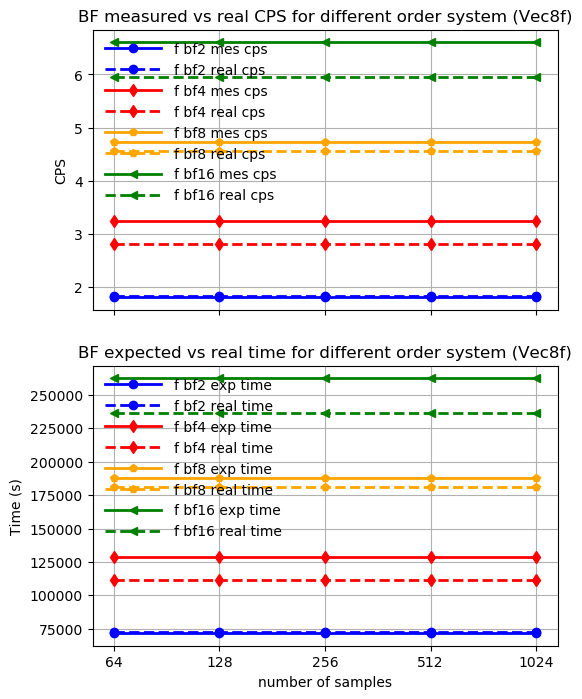

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot: CPS ---
ax1.plot(x, f_bf2_cps8, '-o', label='f bf2 mes cps', color='blue', linewidth=2)
ax1.plot(x, f_bf2_real_cps8, '--o', label='f bf2 real cps', color='blue', linewidth=2)

ax1.plot(x, f_bf4_cps8/2, '-d', label='f bf4 mes cps', color='red', linewidth=2)
ax1.plot(x, f_bf4_real_cps8/2, '--d', label='f bf4 real cps', color='red', linewidth=2)

ax1.plot(x, f_bf8_cps8/4, '-p', label='f bf8 mes cps', color='orange', linewidth=2)
ax1.plot(x, f_bf8_real_cps8/4, '--p', label='f bf8 real cps', color='orange', linewidth=2)

ax1.plot(x, f_bf16_cps8/8, '-<', label='f bf16 mes cps', color='green', linewidth=2)
ax1.plot(x, f_bf16_real_cps8/8, '--<', label='f bf16 real cps', color='green', linewidth=2)

ax1.set_ylabel('CPS')
ax1.set_title('BF measured vs real CPS for different order system (Vec8f)')
ax1.grid(True)
legend1 = ax1.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend1.get_frame().set_alpha(0.0)

# --- Bottom plot: Time ---
ax2.plot(x, f_bf2_exp_time8, '-o', label='f bf2 exp time', color='blue', linewidth=2)
ax2.plot(x, f_bf2_real_time8, '--o', label='f bf2 real time', color='blue', linewidth=2)

ax2.plot(x, f_bf4_exp_time8/2, '-d', label='f bf4 exp time', color='red', linewidth=2)
ax2.plot(x, f_bf4_real_time8/2, '--d', label='f bf4 real time', color='red', linewidth=2)

ax2.plot(x, f_bf8_exp_time8/4, '-p', label='f bf8 exp time', color='orange', linewidth=2)
ax2.plot(x, f_bf8_real_time8/4, '--p', label='f bf8 real time', color='orange', linewidth=2)

ax2.plot(x, f_bf16_exp_time8/8, '-<', label='f bf16 exp time', color='green', linewidth=2)
ax2.plot(x, f_bf16_real_time8/8, '--<', label='f bf16 real time', color='green', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(sample_len)
ax2.set_xlabel('number of samples')
ax2.set_ylabel('Time (s)')
ax2.set_title('BF expected vs real time for different order system (Vec8f)')
ax2.grid(True)
legend2 = ax2.legend(handlelength=4, handletextpad=1.0, framealpha=0.9, loc='upper left')
legend2.get_frame().set_alpha(0.0)

plt.show()


Scalar

In [112]:
bf_pmc = agner_pmc['scalar']
f_sc2_pmc = agner_pmc['filter scalar 2']
f_sc4_pmc = agner_pmc['filter scalar 4']
f_sc8_pmc = agner_pmc['filter scalar 8']
f_sc16_pmc = agner_pmc['filter scalar 16']

f_sc_cps = np.array([f_sc2_pmc[8][1]['cps'],f_sc4_pmc[8][1]['cps'],f_sc8_pmc[8][1]['cps'],f_sc16_pmc[8][1]['cps']])
f_sc_ipc = np.array([f_sc2_pmc[8][1]['ipc'],f_sc4_pmc[8][1]['ipc'],f_sc8_pmc[8][1]['ipc'],f_sc16_pmc[8][1]['ipc']])
f_sc_rss = np.array([f_sc2_pmc[8][1]['rss'],f_sc4_pmc[8][1]['rss'],f_sc8_pmc[8][1]['rss'],f_sc16_pmc[8][1]['rss']])

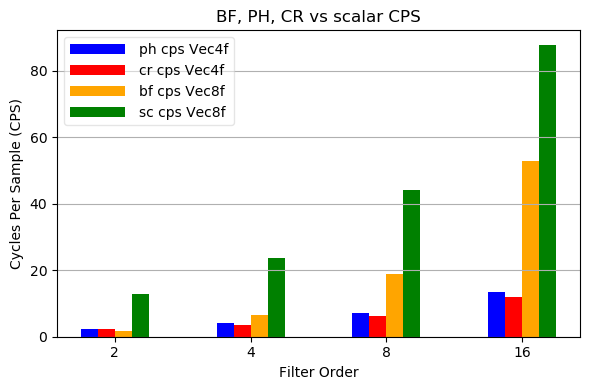

In [106]:
order = [2, 4, 8, 16]
x_order = np.arange(len(order))
bar_width = 0.125

# Shift positions for each bar group
x1 = x_order - 1.5*bar_width
x2 = x_order - 0.5*bar_width
x3 = x_order + 0.5*bar_width
x4 = x_order + 1.5*bar_width

plt.figure(figsize=(6, 4))

plt.bar(x1, f_ph_cps_best, width=bar_width, label='ph cps Vec4f', color='blue')
plt.bar(x2, f_cr_cps_best, width=bar_width, label='cr cps Vec4f', color='red')
plt.bar(x3, f_bf_cps, width=bar_width, label='bf cps Vec8f', color='orange')
plt.bar(x4, f_sc_cps, width=bar_width, label='sc cps Vec8f', color='green')


plt.xticks(x_order, order)
plt.title('BF, PH, CR vs scalar CPS')
plt.xlabel('Filter Order')
plt.ylabel('Cycles Per Sample (CPS)')
plt.grid(True, axis='y')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()


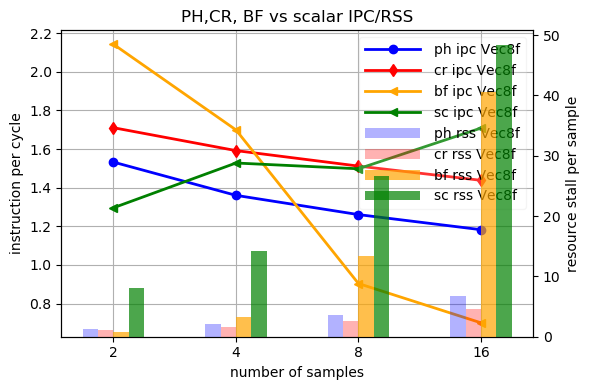

In [113]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)  
ax2 = ax1.twinx()

bar_width = 0.125
x1 = x_order - 1.5*bar_width
x2 = x_order - 0.5*bar_width
x3 = x_order + 0.5*bar_width
x4 = x_order + 1.5*bar_width                 

ax2.bar(x1, f_ph_rss_best, width=bar_width, color='blue', alpha=0.3,label='ph rss Vec8f')
ax2.bar(x2, f_cr_rss_best, width=bar_width, color='red', alpha=0.3, label='cr rss Vec8f')
ax2.bar(x3, f_bf_rss, width=bar_width, color='orange', alpha=0.7,label='bf rss Vec8f')
ax2.bar(x4, f_sc_rss, width=bar_width, color='green', alpha=0.7,label='sc rss Vec8f')

ax1.plot(x_order, f_ph_ipc_best, color='blue', marker='o', linewidth=2, label='ph ipc Vec8f')
ax1.plot(x_order, f_cr_ipc_best, color='red', marker='d', linewidth=2, label='cr ipc Vec8f')
ax1.plot(x_order, f_bf_ipc, color='orange', marker='<', linewidth=2, label='bf ipc Vec8f')
ax1.plot(x_order, f_sc_ipc, color='green', marker='<', linewidth=2, label='sc ipc Vec8f')

ax1.set_xticks(x_order)
ax1.set_xticklabels(order)
ax1.set_xlabel('number of samples')
ax1.set_ylabel('instruction per cycle')
ax2.set_ylabel('resource stall per sample')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.grid(True, which='both')
ax1.set_title('PH,CR, BF vs scalar IPC/RSS')

lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, 
                   handlelength=4, handletextpad=1.0, framealpha=0.9,loc='upper right')
legend.get_frame().set_alpha(0.2)

plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

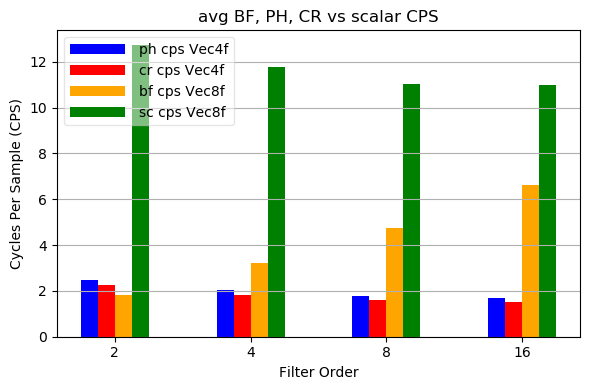

In [119]:
avg_f_sc_cps = np.array([f_sc2_pmc[8][1]['cps'],f_sc4_pmc[8][1]['cps']/2,f_sc8_pmc[8][1]['cps']/4,f_sc16_pmc[8][1]['cps']/8])
avg_f_ph_cps_best = np.array([f_ph2_cps8[bp],f_ph4_cps8[bp]/2,f_ph8_cps8[bp]/4,f_ph16_cps8[bp]/8])
avg_f_cr_cps_best = np.array([f_cr2_cps8[bp],f_cr4_cps8[bp]/2,f_cr8_cps8[bp]/4,f_cr16_cps8[bp]/8])
avg_f_bf_cps = np.array([f_bf2_pmc[8][1]['cps'],f_bf4_pmc[8][1]['cps']/2,f_bf8_pmc[8][1]['cps']/4,f_bf16_pmc[8][1]['cps']/8])

bar_width = 0.125

plt.figure(figsize=(6, 4))

# Shift positions for each bar group
x1 = x_order - 1.5*bar_width
x2 = x_order - 0.5*bar_width
x3 = x_order + 0.5*bar_width
x4 = x_order + 1.5*bar_width

plt.figure(figsize=(6, 4))

plt.bar(x1, avg_f_ph_cps_best, width=bar_width, label='ph cps Vec4f', color='blue')
plt.bar(x2, avg_f_cr_cps_best, width=bar_width, label='cr cps Vec4f', color='red')
plt.bar(x3, avg_f_bf_cps, width=bar_width, label='bf cps Vec8f', color='orange')
plt.bar(x4, avg_f_sc_cps, width=bar_width, label='sc cps Vec8f', color='green')


plt.xticks(x_order, order)
plt.title('avg BF, PH, CR vs scalar CPS')
plt.xlabel('Filter Order')
plt.ylabel('Cycles Per Sample (CPS)')
plt.grid(True, axis='y')
legend = plt.legend(handlelength=4, handletextpad=1.0, framealpha=0.9)
legend.get_frame().set_alpha(0.5)

plt.tight_layout()
plt.show()
